## 1. Import Libraries

In [22]:
# Core libraries
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, fbeta_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve,
    r2_score, mean_squared_error, mean_absolute_error
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Configuration

In [23]:
# Paths
DATA_PATH = r'C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset'
MODELS_DIR = os.path.join(DATA_PATH, 'models_70_15_15')
OUTPUT_DIR = os.path.join(DATA_PATH, 'validation_results')

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configuration
CLUSTER_STOCKS = ['ICICIPRULI', 'ICICIGI', 'HDFCAMC']
OPENING_MINUTES = 60
SEQUENCE_LENGTH = 15

# Splits
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Cross-validation
N_SPLITS = 5

print("✓ Configuration loaded")
print(f"  Stocks: {', '.join(CLUSTER_STOCKS)}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Cross-validation splits: {N_SPLITS}")

✓ Configuration loaded
  Stocks: ICICIPRULI, ICICIGI, HDFCAMC
  Models directory: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\models_70_15_15
  Output directory: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\validation_results
  Cross-validation splits: 5


## 3. Load Pre-trained Models

In [24]:
print("="*80)
print("LOADING PRE-TRAINED MODELS")
print("="*80)

# Load Classification Models
print("\n📊 Loading Classification Models...")
try:
    with open(os.path.join(MODELS_DIR, 'xgboost_classifier.pkl'), 'rb') as f:
        xgb_model = pickle.load(f)
    print("  ✓ XGBoost loaded")
    
    with open(os.path.join(MODELS_DIR, 'lightgbm_classifier.pkl'), 'rb') as f:
        lgbm_model = pickle.load(f)
    print("  ✓ LightGBM loaded")
    
    with open(os.path.join(MODELS_DIR, 'catboost_classifier.pkl'), 'rb') as f:
        cat_model = pickle.load(f)
    print("  ✓ CatBoost loaded")
    
    nn_model_class = keras.models.load_model(os.path.join(MODELS_DIR, 'neural_network_classifier.h5'), compile=False)
    print("  ✓ Neural Network (Classification) loaded")
    
    with open(os.path.join(MODELS_DIR, 'stacking_classifier.pkl'), 'rb') as f:
        stacking_model = pickle.load(f)
    print("  ✓ Stacking Ensemble loaded")
    
    with open(os.path.join(MODELS_DIR, 'feature_scaler.pkl'), 'rb') as f:
        classification_scaler = pickle.load(f)
    print("  ✓ Classification scaler loaded")
    
    with open(os.path.join(MODELS_DIR, 'ensemble_config.pkl'), 'rb') as f:
        ensemble_config = pickle.load(f)
    print("  ✓ Ensemble config loaded")
    
    best_weights = ensemble_config['weights']
    best_threshold = ensemble_config['threshold']
    print(f"  ✓ Ensemble weights: {best_weights}")
    print(f"  ✓ Threshold: {best_threshold:.2f}")
    
except Exception as e:
    print(f"  ⚠️ Error loading classification models: {e}")

# Load Regression Models
print("\n📈 Loading Regression Models...")
try:
    model_high = keras.models.load_model(os.path.join(MODELS_DIR, 'lstm_high_model.h5'), compile=False)
    print("  ✓ LSTM HIGH model loaded")
    
    model_low = keras.models.load_model(os.path.join(MODELS_DIR, 'lstm_low_model.h5'), compile=False)
    print("  ✓ LSTM LOW model loaded")
    
    with open(os.path.join(MODELS_DIR, 'feature_scaler_lstm.pkl'), 'rb') as f:
        regression_scaler = pickle.load(f)
    print("  ✓ Regression feature scaler loaded")
    
    with open(os.path.join(MODELS_DIR, 'high_scaler.pkl'), 'rb') as f:
        high_scaler = pickle.load(f)
    print("  ✓ HIGH target scaler loaded")
    
    with open(os.path.join(MODELS_DIR, 'low_scaler.pkl'), 'rb') as f:
        low_scaler = pickle.load(f)
    print("  ✓ LOW target scaler loaded")
    
    with open(os.path.join(MODELS_DIR, 'regression_config.pkl'), 'rb') as f:
        regression_config = pickle.load(f)
    print("  ✓ Regression config loaded")
    
except Exception as e:
    print(f"  ⚠️ Error loading regression models: {e}")

print("\n" + "="*80)
print("✅ ALL MODELS LOADED SUCCESSFULLY")
print("="*80)

LOADING PRE-TRAINED MODELS

📊 Loading Classification Models...
  ✓ XGBoost loaded
  ✓ LightGBM loaded
  ✓ CatBoost loaded
  ✓ Neural Network (Classification) loaded
  ✓ Stacking Ensemble loaded
  ✓ Classification scaler loaded
  ✓ Ensemble config loaded
  ✓ Ensemble weights: [0.2, 0.2, 0.2, 0.2, 0.2]
  ✓ Threshold: 0.30

📈 Loading Regression Models...
  ✓ LSTM HIGH model loaded
  ✓ LSTM LOW model loaded
  ✓ Regression feature scaler loaded
  ✓ HIGH target scaler loaded
  ✓ LOW target scaler loaded
  ✓ Regression config loaded

✅ ALL MODELS LOADED SUCCESSFULLY


## 4. Load and Prepare Data

In [25]:
print("="*80)
print("LOADING FEATURE DATA")
print("="*80)

# Load feature data
feature_data = {}
minute_data = {}

for stock in CLUSTER_STOCKS:
    # Load features
    feature_file = os.path.join(DATA_PATH, f"{stock}_opening_{OPENING_MINUTES}min_features.csv")
    if os.path.exists(feature_file):
        df = pd.read_csv(feature_file)
        df['date'] = pd.to_datetime(df['date'])
        feature_data[stock] = df
        print(f"✓ {stock}: {len(df)} days loaded")
    else:
        print(f"⚠️ {stock}: Feature file not found")
    
    # Load minute data for classification target
    minute_file = os.path.join(DATA_PATH, f"{stock}_minute.csv")
    if os.path.exists(minute_file):
        df_minute = pd.read_csv(minute_file)
        df_minute['datetime'] = pd.to_datetime(df_minute['date'])
        df_minute['date_only'] = df_minute['datetime'].dt.date
        df_minute['time_only'] = df_minute['datetime'].dt.time
        minute_data[stock] = df_minute

print(f"\n✓ Loaded {len(feature_data)} stocks")

# Define feature columns
feature_cols = [
    'open_price', 'open_high', 'open_low', 'open_close',
    'open_range', 'open_range_pct', 'open_change_pct', 'open_volatility',
    'open_returns_std', 'first_20min_return', 'second_20min_return', 'third_20min_return',
    'avg_volume_per_min', 'volume_trend', 'high_in_first_half', 'low_in_first_half',
    'price_above_open', 'total_volume_opening', 'price_momentum', 'price_acceleration',
    'opening_rsi', 'bb_position', 'volume_surge', 'volume_consistency',
    'hl_ratio', 'upper_shadow_avg', 'lower_shadow_avg', 'trend_strength'
]

print(f"✓ Features: {len(feature_cols)}")

LOADING FEATURE DATA
✓ ICICIPRULI: 2188 days loaded
✓ ICICIGI: 1941 days loaded
✓ HDFCAMC: 1727 days loaded

✓ Loaded 3 stocks
✓ Features: 28


## 5. Prepare Validation Dataset

In [26]:
print("="*80)
print("PREPARING VALIDATION DATASET")
print("="*80)

# Combine all stocks and compute classification target
combined_data = []

for stock in CLUSTER_STOCKS:
    df = feature_data[stock].copy()
    df['stock'] = stock
    df['target'] = 0  # Initialize classification target
    
    if stock in minute_data:
        df_minute = minute_data[stock]
        
        # Compute low_before_high for each day
        for idx, row in df.iterrows():
            date = row['date'].date()
            
            # Get first 60 minutes of trading
            day_data = df_minute[df_minute['date_only'] == date].sort_values('datetime').head(OPENING_MINUTES)
            
            if len(day_data) > 0:
                day_low = day_data['low'].min()
                day_high = day_data['high'].max()
                
                low_idx = day_data[day_data['low'] == day_low].iloc[0]
                high_idx = day_data[day_data['high'] == day_high].iloc[0]
                
                low_time = low_idx['datetime']
                high_time = high_idx['datetime']
                
                # BUY (1) if low occurs before high, SELL (0) otherwise
                df.loc[idx, 'target'] = 1 if low_time < high_time else 0
    
    combined_data.append(df)

combined_df = pd.concat(combined_data, ignore_index=True)
combined_df = combined_df.sort_values(['stock', 'date']).reset_index(drop=True)

print(f"✓ Combined dataset: {len(combined_df)} samples")
print(f"\nTarget distribution:")
print(f"  SELL (0): {(combined_df['target']==0).sum()} ({(combined_df['target']==0).sum()/len(combined_df)*100:.1f}%)")
print(f"  BUY (1):  {(combined_df['target']==1).sum()} ({(combined_df['target']==1).sum()/len(combined_df)*100:.1f}%)")

PREPARING VALIDATION DATASET
✓ Combined dataset: 5856 samples

Target distribution:
  SELL (0): 3096 (52.9%)
  BUY (1):  2760 (47.1%)


In [27]:
# Split data per stock (70/15/15)
print("\n" + "="*80)
print("SPLITTING DATA (VALIDATION SET)")
print("="*80)

val_dfs = []

for stock in CLUSTER_STOCKS:
    stock_df = combined_df[combined_df['stock'] == stock].sort_values('date').reset_index(drop=True)
    stock_len = len(stock_df)
    
    stock_train_size = int(stock_len * TRAIN_SPLIT)
    stock_val_size = int(stock_len * VAL_SPLIT)
    
    # Extract validation set
    stock_val = stock_df.iloc[stock_train_size:stock_train_size+stock_val_size]
    val_dfs.append(stock_val)
    
    print(f"  {stock}: Validation={len(stock_val)} samples")

# Combine validation splits
val_df = pd.concat(val_dfs, ignore_index=True)

print(f"\n✓ Validation set: {len(val_df)} samples")
print(f"\nValidation class distribution:")
print(f"  SELL (0): {(val_df['target']==0).sum()} ({(val_df['target']==0).sum()/len(val_df)*100:.1f}%)")
print(f"  BUY (1):  {(val_df['target']==1).sum()} ({(val_df['target']==1).sum()/len(val_df)*100:.1f}%)")


SPLITTING DATA (VALIDATION SET)
  ICICIPRULI: Validation=328 samples
  ICICIGI: Validation=291 samples
  HDFCAMC: Validation=259 samples

✓ Validation set: 878 samples

Validation class distribution:
  SELL (0): 444 (50.6%)
  BUY (1):  434 (49.4%)


## 6. Classification Predictions on Validation Set

In [28]:
print("="*80)
print("CLASSIFICATION PREDICTIONS - VALIDATION SET")
print("="*80)

# Extract features and targets
X_val = val_df[feature_cols]
y_val = val_df['target']

# Scale features
X_val_scaled = classification_scaler.transform(X_val)

# Get predictions from all models
print("\n📊 Generating predictions from all models...")

y_val_xgb_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
print("  ✓ XGBoost predictions")

y_val_lgbm_proba = lgbm_model.predict_proba(X_val_scaled)[:, 1]
print("  ✓ LightGBM predictions")

y_val_cat_proba = cat_model.predict_proba(X_val_scaled)[:, 1]
print("  ✓ CatBoost predictions")

y_val_nn_proba = nn_model_class.predict(X_val_scaled, verbose=0).flatten()
print("  ✓ Neural Network predictions")

y_val_stack_proba = stacking_model.predict_proba(X_val_scaled)[:, 1]
print("  ✓ Stacking Ensemble predictions")

# Ensemble prediction using optimal weights
y_val_ensemble_proba = (best_weights[0] * y_val_xgb_proba + best_weights[1] * y_val_lgbm_proba +
                        best_weights[2] * y_val_cat_proba + best_weights[3] * y_val_nn_proba +
                        best_weights[4] * y_val_stack_proba)

y_val_pred = (y_val_ensemble_proba >= best_threshold).astype(int)

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f2 = fbeta_score(y_val, y_val_pred, beta=2, zero_division=0)
val_auc = roc_auc_score(y_val, y_val_ensemble_proba)

print(f"\n📊 Validation Set Metrics:")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F2 Score: {val_f2:.4f}")
print(f"  AUC-ROC:  {val_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print(f"\n📋 Confusion Matrix:")
print(f"  TN: {cm[0,0]:4d} | FP: {cm[0,1]:4d}")
print(f"  FN: {cm[1,0]:4d} | TP: {cm[1,1]:4d}")

print("\n" + "="*80)

CLASSIFICATION PREDICTIONS - VALIDATION SET

📊 Generating predictions from all models...
  ✓ XGBoost predictions
  ✓ LightGBM predictions
  ✓ CatBoost predictions
  ✓ Neural Network predictions
  ✓ Stacking Ensemble predictions

📊 Validation Set Metrics:
  Accuracy: 0.8371
  F2 Score: 0.9287
  AUC-ROC:  0.9575

📋 Confusion Matrix:
  TN:  308 | FP:  136
  FN:    7 | TP:  427



## 7. Regression Predictions on Validation Set

In [29]:
print("="*80)
print("REGRESSION PREDICTIONS - VALIDATION SET")
print("="*80)

# Function to create sequences
def create_sequences_per_stock(data_df, feature_cols, sequence_length=15):
    X_seq_list = []
    y_high_list = []
    y_low_list = []
    indices_list = []
    stock_list = []
    
    for stock in data_df['stock'].unique():
        stock_mask = data_df['stock'] == stock
        stock_indices = data_df[stock_mask].index.tolist()
        stock_data = data_df[stock_mask][feature_cols].values
        stock_high = data_df[stock_mask]['day_high'].values
        stock_low = data_df[stock_mask]['day_low'].values
        
        for i in range(sequence_length, len(stock_data)):
            X_seq_list.append(stock_data[i-sequence_length:i])
            y_high_list.append(stock_high[i])
            y_low_list.append(stock_low[i])
            indices_list.append(stock_indices[i])
            stock_list.append(stock)
    
    return (np.array(X_seq_list), np.array(y_high_list), 
            np.array(y_low_list), np.array(indices_list), stock_list)

# Scale features for regression
val_scaled_df = val_df.copy()
X_val_reg_scaled = regression_scaler.transform(val_df[feature_cols])
val_scaled_df[feature_cols] = X_val_reg_scaled

# Create sequences
print("\n📈 Creating sequences for LSTM...")
X_val_seq, y_high_val_seq, y_low_val_seq, val_indices, val_stocks = create_sequences_per_stock(
    val_scaled_df, feature_cols, SEQUENCE_LENGTH)

print(f"  ✓ Validation sequences: {len(X_val_seq)} (from {len(val_df)} samples)")
print(f"  ✓ Lost {SEQUENCE_LENGTH} samples per stock due to sequence creation")

# Make predictions
print("\n📈 Generating LSTM predictions...")

y_high_val_pred_scaled = model_high.predict(X_val_seq, verbose=0)
y_high_val_pred = high_scaler.inverse_transform(y_high_val_pred_scaled).flatten()
print("  ✓ HIGH predictions")

y_low_val_pred_scaled = model_low.predict(X_val_seq, verbose=0)
y_low_val_pred = low_scaler.inverse_transform(y_low_val_pred_scaled).flatten()
print("  ✓ LOW predictions")

# Calculate metrics
high_r2 = r2_score(y_high_val_seq, y_high_val_pred)
high_rmse = np.sqrt(mean_squared_error(y_high_val_seq, y_high_val_pred))
high_mae = mean_absolute_error(y_high_val_seq, y_high_val_pred)
high_mape = np.mean(np.abs((y_high_val_seq - y_high_val_pred) / y_high_val_seq)) * 100

low_r2 = r2_score(y_low_val_seq, y_low_val_pred)
low_rmse = np.sqrt(mean_squared_error(y_low_val_seq, y_low_val_pred))
low_mae = mean_absolute_error(y_low_val_seq, y_low_val_pred)
low_mape = np.mean(np.abs((y_low_val_seq - y_low_val_pred) / y_low_val_seq)) * 100

print(f"\n📈 HIGH Price Prediction:")
print(f"  R² Score:  {high_r2:.4f}")
print(f"  RMSE:      {high_rmse:.2f}")
print(f"  MAE:       {high_mae:.2f}")
print(f"  MAPE:      {high_mape:.2f}%")

print(f"\n📉 LOW Price Prediction:")
print(f"  R² Score:  {low_r2:.4f}")
print(f"  RMSE:      {low_rmse:.2f}")
print(f"  MAE:       {low_mae:.2f}")
print(f"  MAPE:      {low_mape:.2f}%")

# Check violations
violations = (y_low_val_pred > y_high_val_pred).sum()
print(f"\n🔍 Constraint Violations (LOW > HIGH): {violations} / {len(y_low_val_pred)} ({violations/len(y_low_val_pred)*100:.2f}%)")

print("\n" + "="*80)

REGRESSION PREDICTIONS - VALIDATION SET

📈 Creating sequences for LSTM...
  ✓ Validation sequences: 833 (from 878 samples)
  ✓ Lost 15 samples per stock due to sequence creation

📈 Generating LSTM predictions...
  ✓ HIGH predictions
  ✓ LOW predictions

📈 HIGH Price Prediction:
  R² Score:  0.9822
  RMSE:      155.00
  MAE:       103.05
  MAPE:      7.44%

📉 LOW Price Prediction:
  R² Score:  0.9899
  RMSE:      113.38
  MAE:       72.49
  MAPE:      4.30%

🔍 Constraint Violations (LOW > HIGH): 371 / 833 (44.54%)



## 8. Company-wise Performance Analysis

In [30]:
print("="*80)
print("COMPANY-WISE PERFORMANCE ANALYSIS")
print("="*80)

# Classification - Company-wise
print("\n📊 CLASSIFICATION (Company-wise):")
print("-" * 80)

classification_results = []

for stock in CLUSTER_STOCKS:
    stock_mask = val_df['stock'] == stock
    stock_indices = val_df[stock_mask].index
    
    y_true = y_val.loc[stock_indices]
    y_pred_stock = y_val_pred[stock_indices]
    y_proba_stock = y_val_ensemble_proba[stock_indices]
    
    acc = accuracy_score(y_true, y_pred_stock)
    f2 = fbeta_score(y_true, y_pred_stock, beta=2, zero_division=0)
    auc = roc_auc_score(y_true, y_proba_stock)
    
    classification_results.append({
        'Stock': stock,
        'Samples': len(y_true),
        'Accuracy': acc,
        'F2_Score': f2,
        'AUC': auc
    })
    
    print(f"\n{stock}:")
    print(f"  Samples:  {len(y_true)}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F2 Score: {f2:.4f}")
    print(f"  AUC-ROC:  {auc:.4f}")

classification_df = pd.DataFrame(classification_results)

# Regression - Company-wise
print("\n\n📈 REGRESSION (Company-wise):")
print("-" * 80)

regression_results = []

for stock in CLUSTER_STOCKS:
    stock_mask = np.array(val_stocks) == stock
    
    if stock_mask.sum() > 0:
        y_high_true = y_high_val_seq[stock_mask]
        y_high_pred_stock = y_high_val_pred[stock_mask]
        y_low_true = y_low_val_seq[stock_mask]
        y_low_pred_stock = y_low_val_pred[stock_mask]
        
        high_r2_stock = r2_score(y_high_true, y_high_pred_stock)
        high_rmse_stock = np.sqrt(mean_squared_error(y_high_true, y_high_pred_stock))
        low_r2_stock = r2_score(y_low_true, y_low_pred_stock)
        low_rmse_stock = np.sqrt(mean_squared_error(y_low_true, y_low_pred_stock))
        
        violations_stock = (y_low_pred_stock > y_high_pred_stock).sum()
        
        regression_results.append({
            'Stock': stock,
            'Samples': len(y_high_true),
            'HIGH_R2': high_r2_stock,
            'HIGH_RMSE': high_rmse_stock,
            'LOW_R2': low_r2_stock,
            'LOW_RMSE': low_rmse_stock,
            'Violations': violations_stock,
            'Violation_Rate': violations_stock / len(y_high_true) * 100
        })
        
        print(f"\n{stock}:")
        print(f"  Samples:    {len(y_high_true)}")
        print(f"  HIGH R²:    {high_r2_stock:.4f}")
        print(f"  HIGH RMSE:  {high_rmse_stock:.2f}")
        print(f"  LOW R²:     {low_r2_stock:.4f}")
        print(f"  LOW RMSE:   {low_rmse_stock:.2f}")
        print(f"  Violations: {violations_stock} ({violations_stock/len(y_high_true)*100:.2f}%)")

regression_df = pd.DataFrame(regression_results)

print("\n" + "="*80)

COMPANY-WISE PERFORMANCE ANALYSIS

📊 CLASSIFICATION (Company-wise):
--------------------------------------------------------------------------------

ICICIPRULI:
  Samples:  328
  Accuracy: 0.8506
  F2 Score: 0.9385
  AUC-ROC:  0.9550

ICICIGI:
  Samples:  291
  Accuracy: 0.8007
  F2 Score: 0.9091
  AUC-ROC:  0.9501

HDFCAMC:
  Samples:  259
  Accuracy: 0.8610
  F2 Score: 0.9357
  AUC-ROC:  0.9661


📈 REGRESSION (Company-wise):
--------------------------------------------------------------------------------

ICICIPRULI:
  Samples:    313
  HIGH R²:    -0.5403
  HIGH RMSE:  72.74
  LOW R²:     0.7540
  LOW RMSE:   28.24
  Violations: 302 (96.49%)

ICICIGI:
  Samples:    276
  HIGH R²:    0.9245
  HIGH RMSE:  50.73
  LOW R²:     0.8734
  LOW RMSE:   63.49
  Violations: 6 (2.17%)

HDFCAMC:
  Samples:    244
  HIGH R²:    0.7584
  HIGH RMSE:  268.93
  LOW R²:     0.8631
  LOW RMSE:   195.71
  Violations: 63 (25.82%)



## 9. Cross-Validation Analysis

In [31]:
print("="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

cv_classification_results = []
cv_regression_results = []

print(f"\nPerforming {N_SPLITS}-fold Time Series Cross-Validation...")
print("-" * 80)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_val), 1):
    print(f"\nFold {fold}/{N_SPLITS}:")
    print(f"  Train: {len(train_idx)} samples, Val: {len(val_idx)} samples")
    
    # Classification CV
    X_train_cv = X_val_scaled[train_idx]
    X_val_cv = X_val_scaled[val_idx]
    y_train_cv = y_val.iloc[train_idx]
    y_val_cv = y_val.iloc[val_idx]
    
    # Use ensemble predictions (models already trained)
    y_val_cv_proba = y_val_ensemble_proba[val_idx]
    y_val_cv_pred = (y_val_cv_proba >= best_threshold).astype(int)
    
    cv_acc = accuracy_score(y_val_cv, y_val_cv_pred)
    cv_f2 = fbeta_score(y_val_cv, y_val_cv_pred, beta=2, zero_division=0)
    cv_auc = roc_auc_score(y_val_cv, y_val_cv_proba)
    
    cv_classification_results.append({
        'Fold': fold,
        'Train_Size': len(train_idx),
        'Val_Size': len(val_idx),
        'Accuracy': cv_acc,
        'F2_Score': cv_f2,
        'AUC': cv_auc
    })
    
    print(f"  Classification - Acc: {cv_acc:.4f}, F2: {cv_f2:.4f}, AUC: {cv_auc:.4f}")

cv_classification_df = pd.DataFrame(cv_classification_results)

print(f"\n📊 Cross-Validation Summary (Classification):")
print(f"  Mean Accuracy: {cv_classification_df['Accuracy'].mean():.4f} ± {cv_classification_df['Accuracy'].std():.4f}")
print(f"  Mean F2 Score: {cv_classification_df['F2_Score'].mean():.4f} ± {cv_classification_df['F2_Score'].std():.4f}")
print(f"  Mean AUC:      {cv_classification_df['AUC'].mean():.4f} ± {cv_classification_df['AUC'].std():.4f}")

print("\n" + "="*80)

CROSS-VALIDATION ANALYSIS

Performing 5-fold Time Series Cross-Validation...
--------------------------------------------------------------------------------

Fold 1/5:
  Train: 148 samples, Val: 146 samples
  Classification - Acc: 0.8699, F2: 0.9492, AUC: 0.9613

Fold 2/5:
  Train: 294 samples, Val: 146 samples
  Classification - Acc: 0.8151, F2: 0.9191, AUC: 0.9385

Fold 3/5:
  Train: 440 samples, Val: 146 samples
  Classification - Acc: 0.7877, F2: 0.9063, AUC: 0.9521

Fold 4/5:
  Train: 586 samples, Val: 146 samples
  Classification - Acc: 0.9110, F2: 0.9606, AUC: 0.9696

Fold 5/5:
  Train: 732 samples, Val: 146 samples
  Classification - Acc: 0.8082, F2: 0.9066, AUC: 0.9630

📊 Cross-Validation Summary (Classification):
  Mean Accuracy: 0.8384 ± 0.0507
  Mean F2 Score: 0.9284 ± 0.0251
  Mean AUC:      0.9569 ± 0.0121



## 9b. Cross-Validation for Regression

In [32]:
print("="*80)
print("CROSS-VALIDATION ANALYSIS - REGRESSION")
print("="*80)

# Initialize results list for regression CV
cv_regression_results = []

# Perform Time Series CV on regression sequences with company-wise splitting
print(f"\nPerforming {N_SPLITS}-fold Time Series Cross-Validation for Regression...")
print("Using company-wise splits to maintain temporal order...")
print("-" * 80)

# Create sequences per company for better CV
company_sequences = {}
for stock in CLUSTER_STOCKS:
    stock_mask = np.array(val_stocks) == stock
    company_sequences[stock] = {
        'X': X_val_seq[stock_mask],
        'y_high': y_high_val_seq[stock_mask],
        'y_low': y_low_val_seq[stock_mask],
        'indices': np.where(stock_mask)[0]
    }

# Perform time series CV per company
for fold in range(1, N_SPLITS + 1):
    fold_X = []
    fold_y_high = []
    fold_y_low = []
    
    for stock in CLUSTER_STOCKS:
        stock_data = company_sequences[stock]
        n_samples = len(stock_data['X'])
        
        # Calculate fold size ensuring minimum samples
        fold_size = max(n_samples // N_SPLITS, 1)
        
        # Calculate start and end indices for this fold
        val_start = (fold - 1) * fold_size
        val_end = min(fold * fold_size, n_samples)
        
        # For last fold, take all remaining samples
        if fold == N_SPLITS:
            val_end = n_samples
        
        if val_end > val_start:
            fold_X.append(stock_data['X'][val_start:val_end])
            fold_y_high.append(stock_data['y_high'][val_start:val_end])
            fold_y_low.append(stock_data['y_low'][val_start:val_end])
    
    # Concatenate all companies for this fold
    if len(fold_X) > 0:
        X_val_fold = np.concatenate(fold_X)
        y_high_val_fold = np.concatenate(fold_y_high)
        y_low_val_fold = np.concatenate(fold_y_low)
        
        print(f"\nFold {fold}/{N_SPLITS}:")
        print(f"  Total validation sequences: {len(X_val_fold)}")
        
        # Make predictions
        y_high_pred_fold_scaled = model_high.predict(X_val_fold, verbose=0)
        y_high_pred_fold = high_scaler.inverse_transform(y_high_pred_fold_scaled).flatten()
        
        y_low_pred_fold_scaled = model_low.predict(X_val_fold, verbose=0)
        y_low_pred_fold = low_scaler.inverse_transform(y_low_pred_fold_scaled).flatten()
        
        # Calculate metrics
        fold_high_r2 = r2_score(y_high_val_fold, y_high_pred_fold)
        fold_high_rmse = np.sqrt(mean_squared_error(y_high_val_fold, y_high_pred_fold))
        fold_high_mae = mean_absolute_error(y_high_val_fold, y_high_pred_fold)
        
        fold_low_r2 = r2_score(y_low_val_fold, y_low_pred_fold)
        fold_low_rmse = np.sqrt(mean_squared_error(y_low_val_fold, y_low_pred_fold))
        fold_low_mae = mean_absolute_error(y_low_val_fold, y_low_pred_fold)
        
        fold_violations = (y_low_pred_fold > y_high_pred_fold).sum()
        
        cv_regression_results.append({
            'Fold': fold,
            'Val_Size': len(X_val_fold),
            'HIGH_R2': fold_high_r2,
            'HIGH_RMSE': fold_high_rmse,
            'HIGH_MAE': fold_high_mae,
            'LOW_R2': fold_low_r2,
            'LOW_RMSE': fold_low_rmse,
            'LOW_MAE': fold_low_mae,
            'Violations': fold_violations,
            'Violation_Rate': fold_violations / len(X_val_fold) * 100
        })
        
        print(f"  HIGH - R²: {fold_high_r2:.4f}, RMSE: {fold_high_rmse:.2f}, MAE: {fold_high_mae:.2f}")
        print(f"  LOW  - R²: {fold_low_r2:.4f}, RMSE: {fold_low_rmse:.2f}, MAE: {fold_low_mae:.2f}")
        print(f"  Violations: {fold_violations} ({fold_violations/len(X_val_fold)*100:.2f}%)")

cv_regression_df = pd.DataFrame(cv_regression_results)

print(f"\n📈 Cross-Validation Summary (Regression):")
print(f"\nHIGH Price Prediction:")
print(f"  Mean R²:   {cv_regression_df['HIGH_R2'].mean():.4f} ± {cv_regression_df['HIGH_R2'].std():.4f}")
print(f"  Mean RMSE: {cv_regression_df['HIGH_RMSE'].mean():.2f} ± {cv_regression_df['HIGH_RMSE'].std():.2f}")
print(f"  Mean MAE:  {cv_regression_df['HIGH_MAE'].mean():.2f} ± {cv_regression_df['HIGH_MAE'].std():.2f}")

print(f"\nLOW Price Prediction:")
print(f"  Mean R²:   {cv_regression_df['LOW_R2'].mean():.4f} ± {cv_regression_df['LOW_R2'].std():.4f}")
print(f"  Mean RMSE: {cv_regression_df['LOW_RMSE'].mean():.2f} ± {cv_regression_df['LOW_RMSE'].std():.2f}")
print(f"  Mean MAE:  {cv_regression_df['LOW_MAE'].mean():.2f} ± {cv_regression_df['LOW_MAE'].std():.2f}")

print(f"\nConstraint Violations:")
print(f"  Mean Rate: {cv_regression_df['Violation_Rate'].mean():.2f}% ± {cv_regression_df['Violation_Rate'].std():.2f}%")

print("\n" + "="*80)

CROSS-VALIDATION ANALYSIS - REGRESSION

Performing 5-fold Time Series Cross-Validation for Regression...
Using company-wise splits to maintain temporal order...
--------------------------------------------------------------------------------

Fold 1/5:
  Total validation sequences: 165
  HIGH - R²: 0.9922, RMSE: 74.86, MAE: 57.98
  LOW  - R²: 0.9927, RMSE: 70.11, MAE: 52.64
  Violations: 59 (35.76%)

Fold 2/5:
  Total validation sequences: 165
  HIGH - R²: 0.9941, RMSE: 71.81, MAE: 54.00
  LOW  - R²: 0.9959, RMSE: 58.57, MAE: 42.85
  Violations: 60 (36.36%)

Fold 3/5:
  Total validation sequences: 165
  HIGH - R²: 0.9843, RMSE: 141.17, MAE: 107.71
  LOW  - R²: 0.9919, RMSE: 98.93, MAE: 69.56
  Violations: 71 (43.03%)

Fold 4/5:
  Total validation sequences: 165
  HIGH - R²: 0.9812, RMSE: 178.78, MAE: 132.21
  LOW  - R²: 0.9903, RMSE: 124.85, MAE: 89.40
  Violations: 89 (53.94%)

Fold 5/5:
  Total validation sequences: 173
  HIGH - R²: 0.9706, RMSE: 236.49, MAE: 160.56
  LOW  - R²: 0.98

## 10. Export Results to CSV

In [33]:
print("="*80)
print("EXPORTING RESULTS TO CSV")
print("="*80)

# Map buy/sell labels to text
val_df['buy_sell_label'] = pd.Series(y_val_pred).map({1: 'BUY', 0: 'SELL'}).values
val_df['buy_sell_proba'] = y_val_ensemble_proba

# 1. Classification predictions (company-wise)
classification_output = val_df[['date', 'stock', 'target', 'buy_sell_label', 'buy_sell_proba']].copy()
classification_output['target_label'] = classification_output['target'].map({1: 'BUY', 0: 'SELL'})
classification_output['correct'] = (classification_output['target'] == y_val_pred).astype(int)

classification_csv = os.path.join(OUTPUT_DIR, 'validation_classification_predictions.csv')
classification_output.to_csv(classification_csv, index=False)
print(f"✓ Classification predictions saved: {classification_csv}")

# 2. Integrated predictions (company-wise) - matching integrated_model_pipeline format
# Create dataframe for samples with both classification and regression predictions
integrated_results = []

for idx in val_indices:
    if idx in val_df.index:
        row = val_df.loc[idx]
        seq_idx = np.where(val_indices == idx)[0]
        
        if len(seq_idx) > 0:
            integrated_results.append({
                'date': row['date'],
                'stock': row['stock'],
                'volume': row['total_volume_opening'],
                'actual_high': row['day_high'],
                'actual_low': row['day_low'],
                'predicted_low': y_low_val_pred[seq_idx[0]],
                'predicted_high': y_high_val_pred[seq_idx[0]],
                'buy_sell_label': row['buy_sell_label']
            })

integrated_df = pd.DataFrame(integrated_results)

# Save integrated results per company (matching integrated_model_pipeline format)
print(f"\n📊 Generating Company-wise Integrated CSV Files:")
for stock in CLUSTER_STOCKS:
    stock_integrated = integrated_df[integrated_df['stock'] == stock].copy()
    
    # Drop stock column and save
    stock_output = stock_integrated.drop('stock', axis=1)
    
    integrated_csv = os.path.join(OUTPUT_DIR, f'{stock}_validation_integrated.csv')
    stock_output.to_csv(integrated_csv, index=False)
    
    buy_count = (stock_output['buy_sell_label'] == 'BUY').sum()
    sell_count = (stock_output['buy_sell_label'] == 'SELL').sum()
    
    print(f"\n  {stock}:")
    print(f"    File: {integrated_csv}")
    print(f"    Samples: {len(stock_output)}")
    print(f"    BUY signals:  {buy_count} ({buy_count/len(stock_output)*100:.1f}%)")
    print(f"    SELL signals: {sell_count} ({sell_count/len(stock_output)*100:.1f}%)")

# 3. Regression predictions (detailed, for analysis)
regression_output = pd.DataFrame({
    'stock': val_stocks,
    'actual_high': y_high_val_seq,
    'predicted_high': y_high_val_pred,
    'actual_low': y_low_val_seq,
    'predicted_low': y_low_val_pred,
    'high_error': np.abs(y_high_val_seq - y_high_val_pred),
    'low_error': np.abs(y_low_val_seq - y_low_val_pred),
    'violation': (y_low_val_pred > y_high_val_pred).astype(int)
})

regression_csv = os.path.join(OUTPUT_DIR, 'validation_regression_predictions_detailed.csv')
regression_output.to_csv(regression_csv, index=False)
print(f"\n✓ Detailed regression predictions saved: {regression_csv}")


# 4. Company-wise classification summary
classification_summary_csv = os.path.join(OUTPUT_DIR, 'company_wise_classification.csv')
classification_df.to_csv(classification_summary_csv, index=False)
print(f"\n✓ Company-wise classification summary saved: {classification_summary_csv}")

# 5. Company-wise regression summary
regression_summary_csv = os.path.join(OUTPUT_DIR, 'company_wise_regression.csv')
regression_df.to_csv(regression_summary_csv, index=False)
print(f"✓ Company-wise regression summary saved: {regression_summary_csv}")

# 6. Cross-validation results (Classification)
cv_classification_csv = os.path.join(OUTPUT_DIR, 'cross_validation_classification.csv')
cv_classification_df.to_csv(cv_classification_csv, index=False)
print(f"✓ Cross-validation (classification) results saved: {cv_classification_csv}")

# 7. Cross-validation results (Regression)
cv_regression_csv = os.path.join(OUTPUT_DIR, 'cross_validation_regression.csv')
cv_regression_df.to_csv(cv_regression_csv, index=False)
print(f"✓ Cross-validation (regression) results saved: {cv_regression_csv}")

print("\n" + "="*80)
print("✅ ALL RESULTS EXPORTED TO CSV")
print("="*80)
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"\nKey files (matching integrated_model_pipeline format):")
for stock in CLUSTER_STOCKS:
    print(f"  • {stock}_validation_integrated.csv")

EXPORTING RESULTS TO CSV
✓ Classification predictions saved: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\validation_results\validation_classification_predictions.csv

📊 Generating Company-wise Integrated CSV Files:

  ICICIPRULI:
    File: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\validation_results\ICICIPRULI_validation_integrated.csv
    Samples: 313
    BUY signals:  207 (66.1%)
    SELL signals: 106 (33.9%)

  ICICIGI:
    File: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\validation_results\ICICIGI_validation_integrated.csv
    Samples: 276
    BUY signals:  175 (63.4%)
    SELL signals: 101 (36.6%)

  HDFCAMC:
    File: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\validation_results\HDFCAMC_va

## 11. Visualization - Classification Performance

## 11b. Visualization - Classification Cross-Validation (Fold-wise)

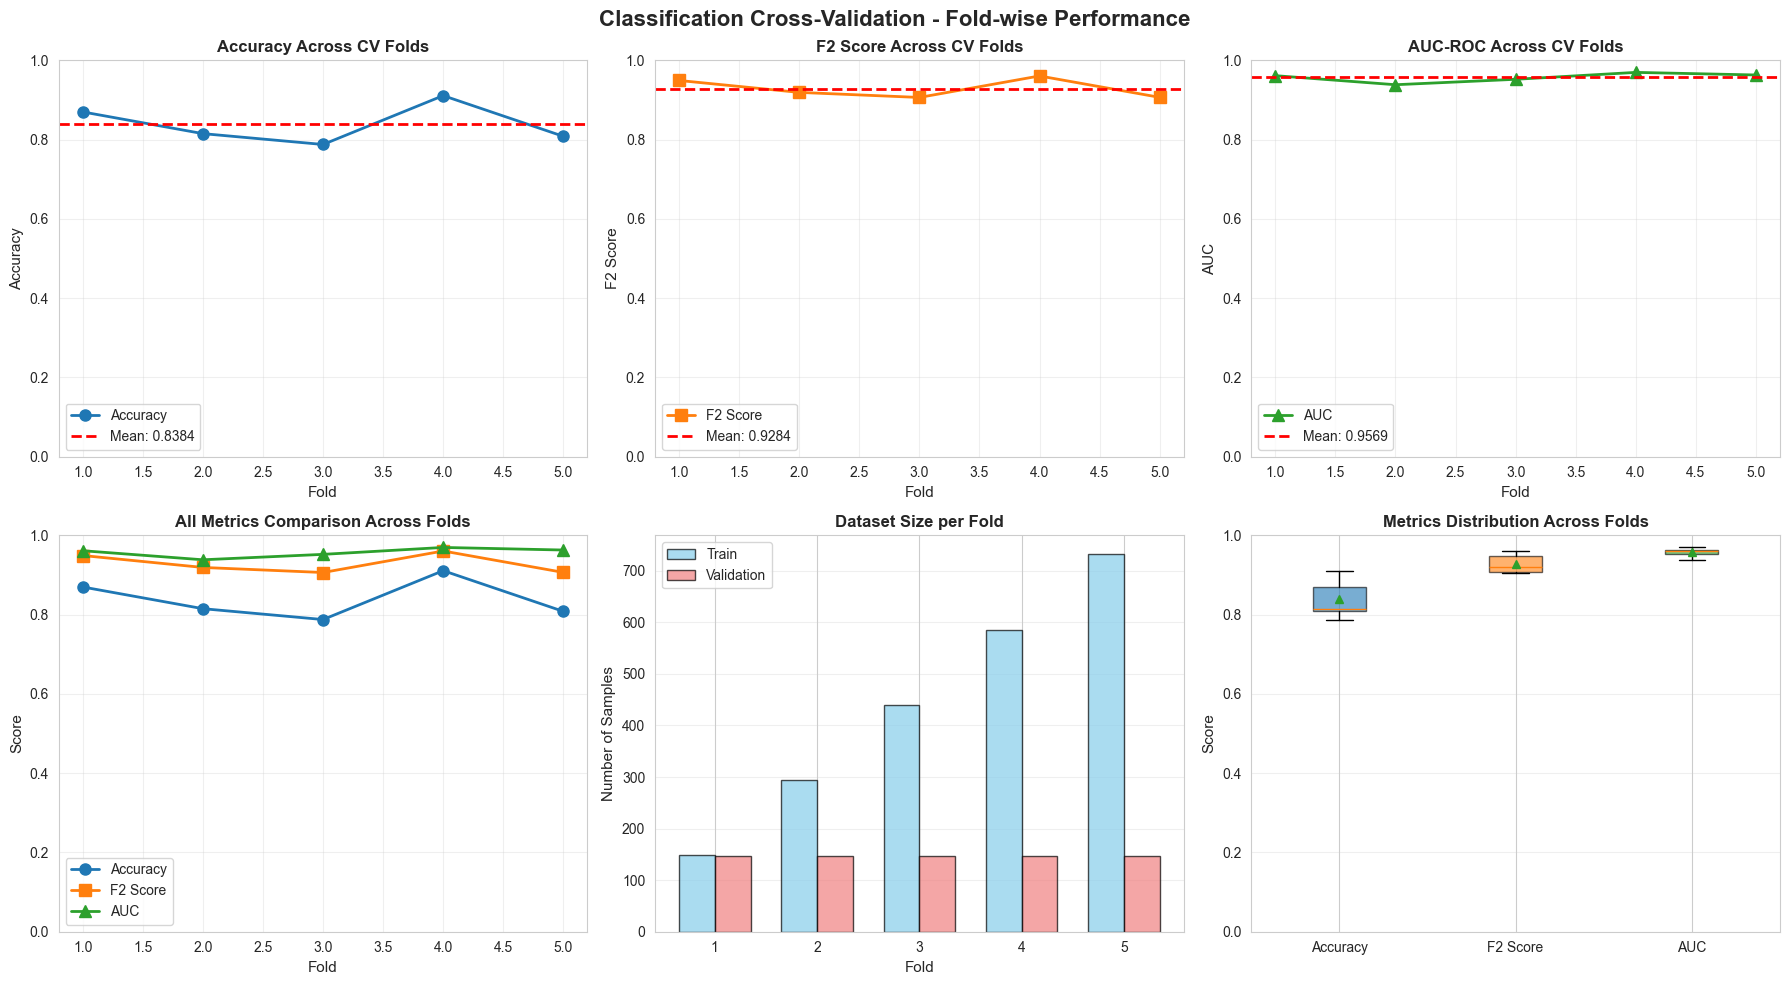


📊 Classification CV Statistics:
  Accuracy - Min: 0.7877, Max: 0.9110, Std: 0.0507
  F2 Score - Min: 0.9063, Max: 0.9606, Std: 0.0251
  AUC      - Min: 0.9385, Max: 0.9696, Std: 0.0121

✓ Classification cross-validation fold-wise visualization saved


In [34]:
# Classification Cross-Validation Fold-wise Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Accuracy across folds
ax1 = axes[0, 0]
ax1.plot(cv_classification_df['Fold'], cv_classification_df['Accuracy'], 'o-',
         linewidth=2, markersize=8, color='#1f77b4', label='Accuracy')
ax1.axhline(y=cv_classification_df['Accuracy'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_classification_df['Accuracy'].mean():.4f}")
ax1.set_title('Accuracy Across CV Folds', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fold', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(alpha=0.3)

# 2. F2 Score across folds
ax2 = axes[0, 1]
ax2.plot(cv_classification_df['Fold'], cv_classification_df['F2_Score'], 's-',
         linewidth=2, markersize=8, color='#ff7f0e', label='F2 Score')
ax2.axhline(y=cv_classification_df['F2_Score'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_classification_df['F2_Score'].mean():.4f}")
ax2.set_title('F2 Score Across CV Folds', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fold', fontsize=11)
ax2.set_ylabel('F2 Score', fontsize=11)
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(alpha=0.3)

# 3. AUC across folds
ax3 = axes[0, 2]
ax3.plot(cv_classification_df['Fold'], cv_classification_df['AUC'], '^-',
         linewidth=2, markersize=8, color='#2ca02c', label='AUC')
ax3.axhline(y=cv_classification_df['AUC'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_classification_df['AUC'].mean():.4f}")
ax3.set_title('AUC-ROC Across CV Folds', fontsize=12, fontweight='bold')
ax3.set_xlabel('Fold', fontsize=11)
ax3.set_ylabel('AUC', fontsize=11)
ax3.set_ylim([0, 1])
ax3.legend()
ax3.grid(alpha=0.3)

# 4. All metrics comparison
ax4 = axes[1, 0]
x_folds = cv_classification_df['Fold']
ax4.plot(x_folds, cv_classification_df['Accuracy'], 'o-', linewidth=2, markersize=8,
         color='#1f77b4', label='Accuracy')
ax4.plot(x_folds, cv_classification_df['F2_Score'], 's-', linewidth=2, markersize=8,
         color='#ff7f0e', label='F2 Score')
ax4.plot(x_folds, cv_classification_df['AUC'], '^-', linewidth=2, markersize=8,
         color='#2ca02c', label='AUC')
ax4.set_title('All Metrics Comparison Across Folds', fontsize=12, fontweight='bold')
ax4.set_xlabel('Fold', fontsize=11)
ax4.set_ylabel('Score', fontsize=11)
ax4.set_ylim([0, 1])
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Train/Val size per fold
ax5 = axes[1, 1]
x = np.arange(len(cv_classification_df))
width = 0.35
bars1 = ax5.bar(x - width/2, cv_classification_df['Train_Size'], width, label='Train',
                color='skyblue', edgecolor='black', alpha=0.7)
bars2 = ax5.bar(x + width/2, cv_classification_df['Val_Size'], width, label='Validation',
                color='lightcoral', edgecolor='black', alpha=0.7)
ax5.set_title('Dataset Size per Fold', fontsize=12, fontweight='bold')
ax5.set_ylabel('Number of Samples', fontsize=11)
ax5.set_xlabel('Fold', fontsize=11)
ax5.set_xticks(x)
ax5.set_xticklabels(cv_classification_df['Fold'])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Metrics variance (box plot style)
ax6 = axes[1, 2]
metrics_data = [cv_classification_df['Accuracy'], 
                cv_classification_df['F2_Score'], 
                cv_classification_df['AUC']]
bp = ax6.boxplot(metrics_data, labels=['Accuracy', 'F2 Score', 'AUC'],
                 patch_artist=True, showmeans=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax6.set_title('Metrics Distribution Across Folds', fontsize=12, fontweight='bold')
ax6.set_ylabel('Score', fontsize=11)
ax6.set_ylim([0, 1])
ax6.grid(axis='y', alpha=0.3)

plt.suptitle('Classification Cross-Validation - Fold-wise Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'classification_cross_validation_foldwise.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Classification CV Statistics:")
print(f"  Accuracy - Min: {cv_classification_df['Accuracy'].min():.4f}, Max: {cv_classification_df['Accuracy'].max():.4f}, Std: {cv_classification_df['Accuracy'].std():.4f}")
print(f"  F2 Score - Min: {cv_classification_df['F2_Score'].min():.4f}, Max: {cv_classification_df['F2_Score'].max():.4f}, Std: {cv_classification_df['F2_Score'].std():.4f}")
print(f"  AUC      - Min: {cv_classification_df['AUC'].min():.4f}, Max: {cv_classification_df['AUC'].max():.4f}, Std: {cv_classification_df['AUC'].std():.4f}")

print("\n✓ Classification cross-validation fold-wise visualization saved")

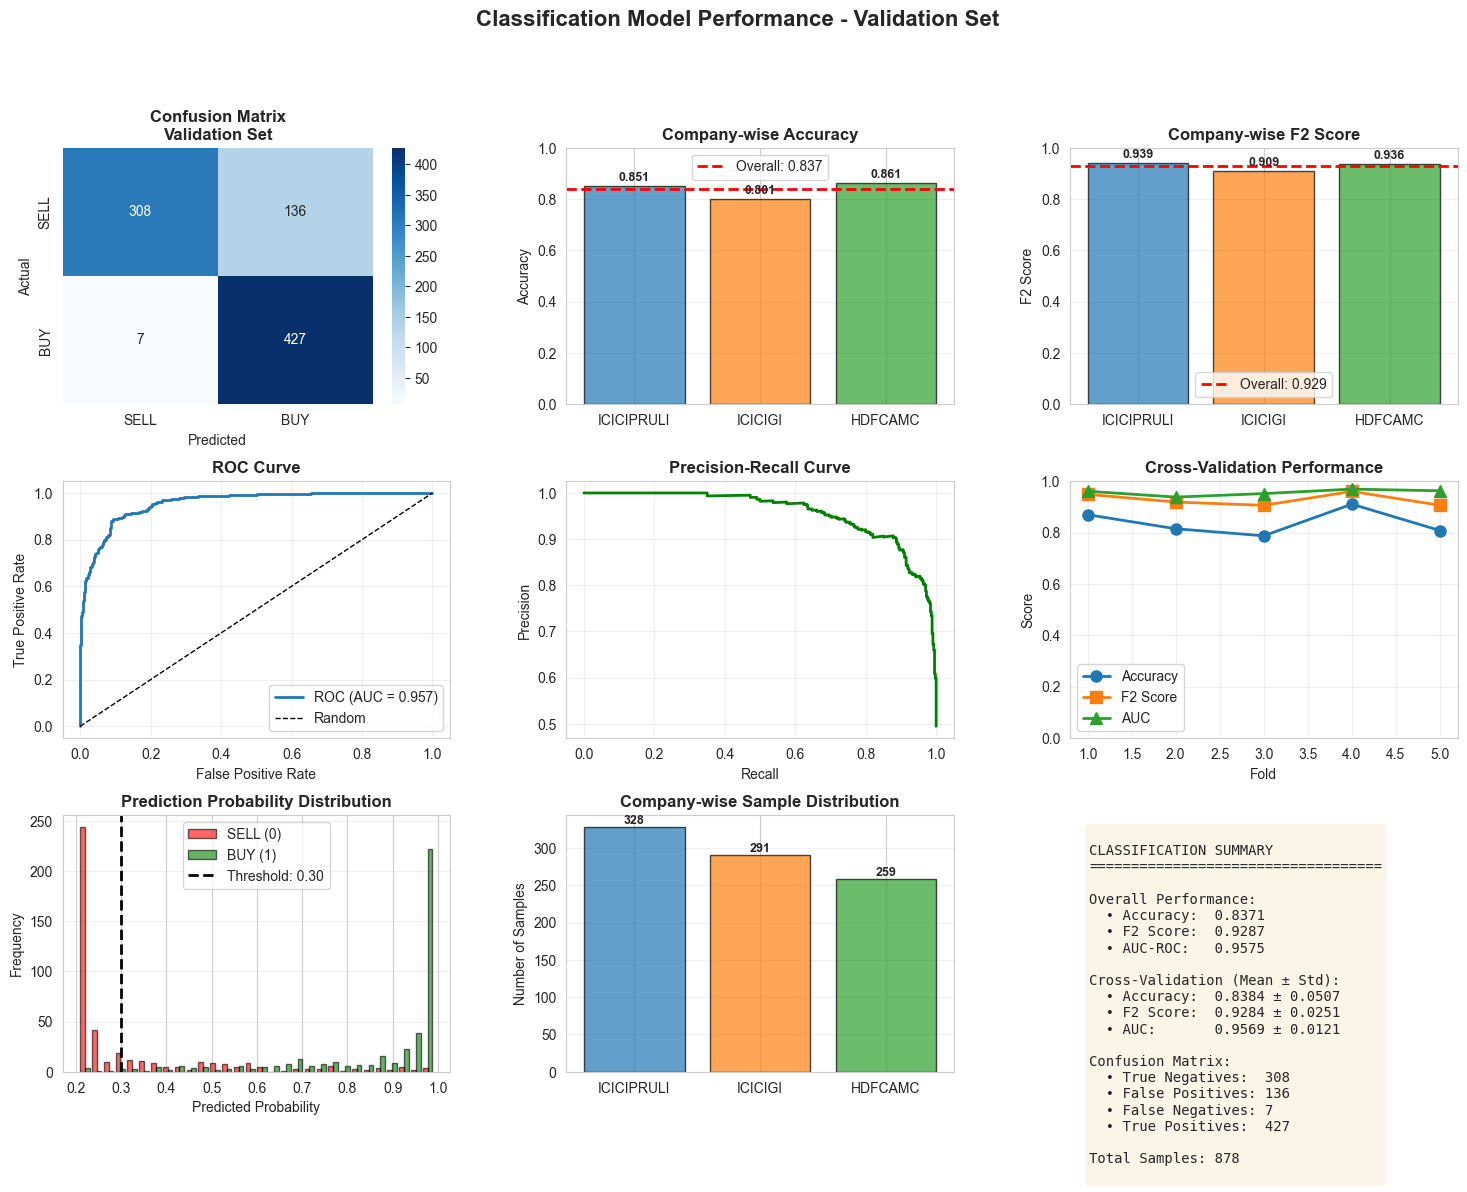

✓ Classification visualization saved


In [35]:
# Classification Visualizations
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['SELL', 'BUY'], yticklabels=['SELL', 'BUY'])
ax1.set_title('Confusion Matrix\nValidation Set', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# 2. Company-wise Accuracy
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(classification_df['Stock'], classification_df['Accuracy'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', alpha=0.7)
ax2.axhline(y=val_accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {val_accuracy:.3f}')
ax2.set_title('Company-wise Accuracy', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Company-wise F2 Score
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(classification_df['Stock'], classification_df['F2_Score'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', alpha=0.7)
ax3.axhline(y=val_f2, color='red', linestyle='--', linewidth=2, label=f'Overall: {val_f2:.3f}')
ax3.set_title('Company-wise F2 Score', fontsize=12, fontweight='bold')
ax3.set_ylabel('F2 Score')
ax3.set_ylim([0, 1])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. ROC Curve
ax4 = fig.add_subplot(gs[1, 0])
fpr, tpr, _ = roc_curve(y_val, y_val_ensemble_proba)
ax4.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {val_auc:.3f})')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax4.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Precision-Recall Curve
ax5 = fig.add_subplot(gs[1, 1])
precision, recall, _ = precision_recall_curve(y_val, y_val_ensemble_proba)
ax5.plot(recall, precision, linewidth=2, color='green')
ax5.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.grid(alpha=0.3)

# 6. Cross-Validation Performance
ax6 = fig.add_subplot(gs[1, 2])
x_folds = cv_classification_df['Fold']
ax6.plot(x_folds, cv_classification_df['Accuracy'], 'o-', linewidth=2, markersize=8, label='Accuracy')
ax6.plot(x_folds, cv_classification_df['F2_Score'], 's-', linewidth=2, markersize=8, label='F2 Score')
ax6.plot(x_folds, cv_classification_df['AUC'], '^-', linewidth=2, markersize=8, label='AUC')
ax6.set_title('Cross-Validation Performance', fontsize=12, fontweight='bold')
ax6.set_xlabel('Fold')
ax6.set_ylabel('Score')
ax6.set_ylim([0, 1])
ax6.legend()
ax6.grid(alpha=0.3)

# 7. Prediction Distribution
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist([y_val_ensemble_proba[y_val == 0], y_val_ensemble_proba[y_val == 1]], 
         bins=30, label=['SELL (0)', 'BUY (1)'], color=['red', 'green'], alpha=0.6, edgecolor='black')
ax7.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold:.2f}')
ax7.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
ax7.set_xlabel('Predicted Probability')
ax7.set_ylabel('Frequency')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

# 8. Company-wise Sample Distribution
ax8 = fig.add_subplot(gs[2, 1])
bars = ax8.bar(classification_df['Stock'], classification_df['Samples'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', alpha=0.7)
ax8.set_title('Company-wise Sample Distribution', fontsize=12, fontweight='bold')
ax8.set_ylabel('Number of Samples')
ax8.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 9. Overall Metrics Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f"""
CLASSIFICATION SUMMARY
{'='*35}

Overall Performance:
  • Accuracy:  {val_accuracy:.4f}
  • F2 Score:  {val_f2:.4f}
  • AUC-ROC:   {val_auc:.4f}

Cross-Validation (Mean ± Std):
  • Accuracy:  {cv_classification_df['Accuracy'].mean():.4f} ± {cv_classification_df['Accuracy'].std():.4f}
  • F2 Score:  {cv_classification_df['F2_Score'].mean():.4f} ± {cv_classification_df['F2_Score'].std():.4f}
  • AUC:       {cv_classification_df['AUC'].mean():.4f} ± {cv_classification_df['AUC'].std():.4f}

Confusion Matrix:
  • True Negatives:  {cm[0,0]}
  • False Positives: {cm[0,1]}
  • False Negatives: {cm[1,0]}
  • True Positives:  {cm[1,1]}

Total Samples: {len(y_val)}
"""
ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, 
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Classification Model Performance - Validation Set', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(os.path.join(OUTPUT_DIR, 'classification_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Classification visualization saved")

## 12. Visualization - Regression Performance

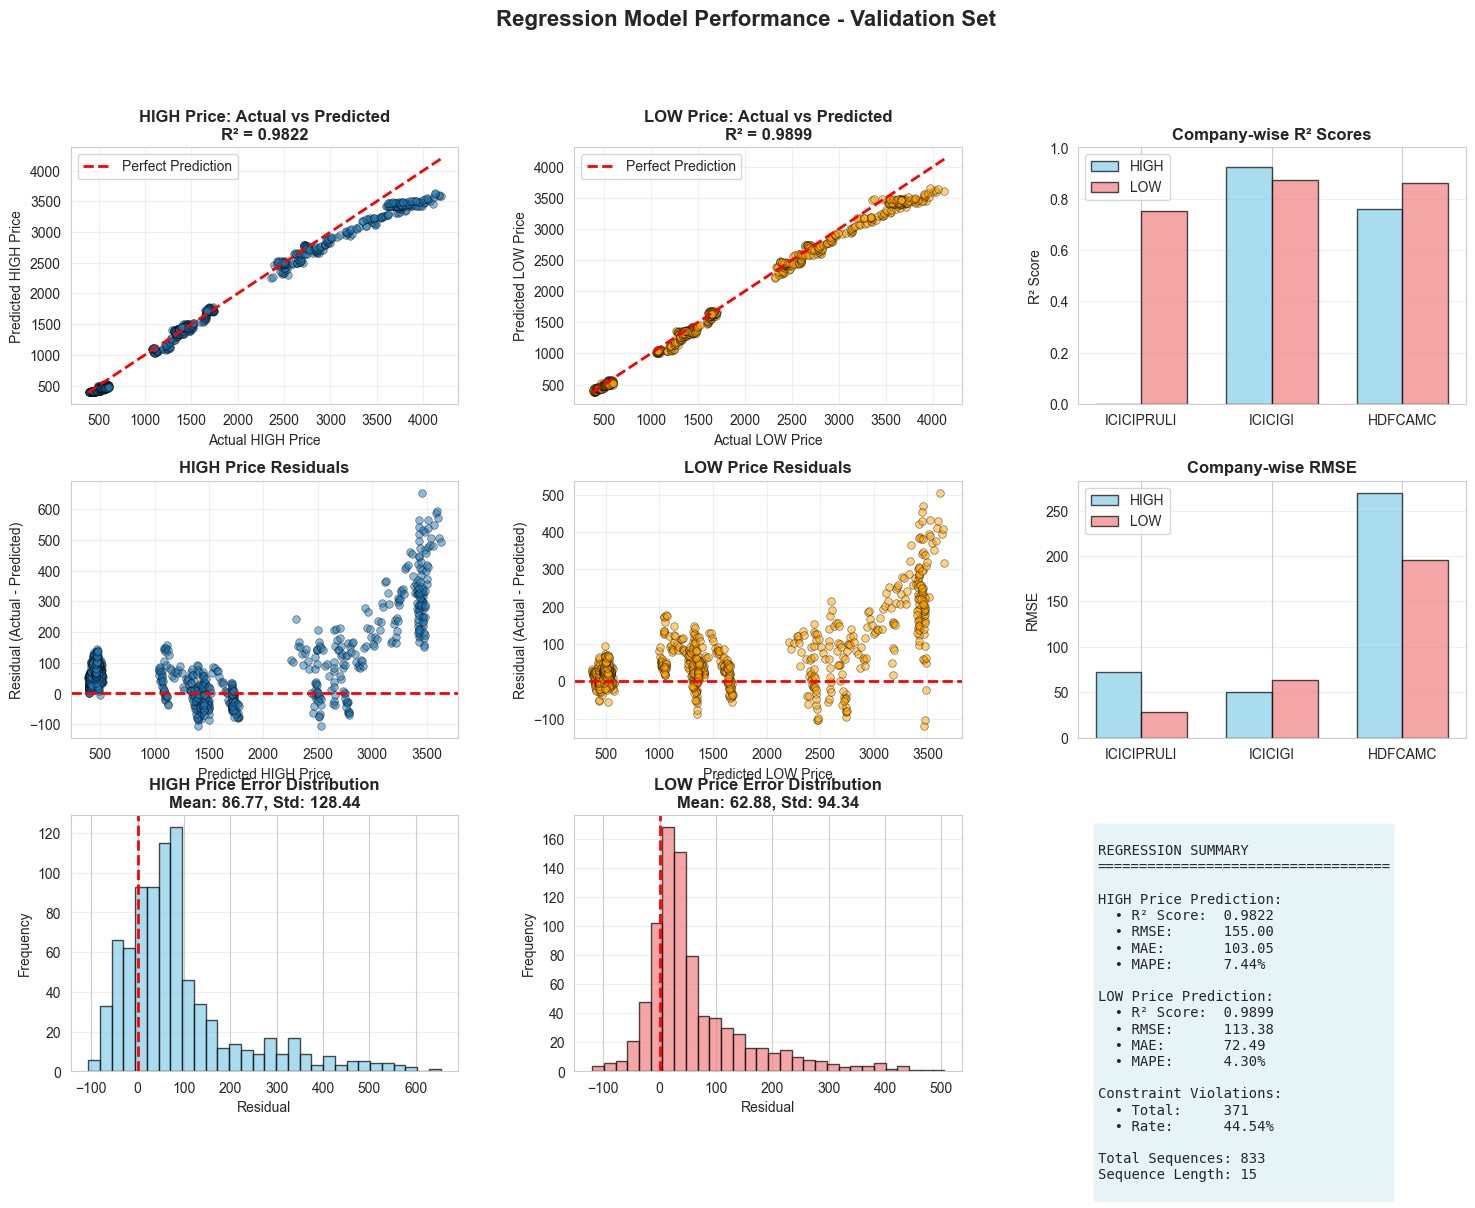

✓ Regression visualization saved


In [36]:
# Regression Visualizations
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. HIGH: Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_high_val_seq, y_high_val_pred, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
min_val = min(y_high_val_seq.min(), y_high_val_pred.min())
max_val = max(y_high_val_seq.max(), y_high_val_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_title(f'HIGH Price: Actual vs Predicted\nR² = {high_r2:.4f}', fontsize=12, fontweight='bold')
ax1.set_xlabel('Actual HIGH Price')
ax1.set_ylabel('Predicted HIGH Price')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. LOW: Actual vs Predicted
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_low_val_seq, y_low_val_pred, alpha=0.5, s=30, color='orange', edgecolors='black', linewidth=0.5)
min_val = min(y_low_val_seq.min(), y_low_val_pred.min())
max_val = max(y_low_val_seq.max(), y_low_val_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title(f'LOW Price: Actual vs Predicted\nR² = {low_r2:.4f}', fontsize=12, fontweight='bold')
ax2.set_xlabel('Actual LOW Price')
ax2.set_ylabel('Predicted LOW Price')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Company-wise R² Scores
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(regression_df))
width = 0.35
bars1 = ax3.bar(x - width/2, regression_df['HIGH_R2'], width, label='HIGH', 
                color='skyblue', edgecolor='black', alpha=0.7)
bars2 = ax3.bar(x + width/2, regression_df['LOW_R2'], width, label='LOW',
                color='lightcoral', edgecolor='black', alpha=0.7)
ax3.set_title('Company-wise R² Scores', fontsize=12, fontweight='bold')
ax3.set_ylabel('R² Score')
ax3.set_xticks(x)
ax3.set_xticklabels(regression_df['Stock'])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# 4. HIGH Residuals
ax4 = fig.add_subplot(gs[1, 0])
residuals_high = y_high_val_seq - y_high_val_pred
ax4.scatter(y_high_val_pred, residuals_high, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax4.set_title('HIGH Price Residuals', fontsize=12, fontweight='bold')
ax4.set_xlabel('Predicted HIGH Price')
ax4.set_ylabel('Residual (Actual - Predicted)')
ax4.grid(alpha=0.3)

# 5. LOW Residuals
ax5 = fig.add_subplot(gs[1, 1])
residuals_low = y_low_val_seq - y_low_val_pred
ax5.scatter(y_low_val_pred, residuals_low, alpha=0.5, s=30, color='orange', edgecolors='black', linewidth=0.5)
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_title('LOW Price Residuals', fontsize=12, fontweight='bold')
ax5.set_xlabel('Predicted LOW Price')
ax5.set_ylabel('Residual (Actual - Predicted)')
ax5.grid(alpha=0.3)

# 6. Company-wise RMSE
ax6 = fig.add_subplot(gs[1, 2])
x = np.arange(len(regression_df))
bars1 = ax6.bar(x - width/2, regression_df['HIGH_RMSE'], width, label='HIGH',
                color='skyblue', edgecolor='black', alpha=0.7)
bars2 = ax6.bar(x + width/2, regression_df['LOW_RMSE'], width, label='LOW',
                color='lightcoral', edgecolor='black', alpha=0.7)
ax6.set_title('Company-wise RMSE', fontsize=12, fontweight='bold')
ax6.set_ylabel('RMSE')
ax6.set_xticks(x)
ax6.set_xticklabels(regression_df['Stock'])
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Error Distribution (HIGH)
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(residuals_high, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax7.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax7.set_title(f'HIGH Price Error Distribution\nMean: {residuals_high.mean():.2f}, Std: {residuals_high.std():.2f}', 
              fontsize=12, fontweight='bold')
ax7.set_xlabel('Residual')
ax7.set_ylabel('Frequency')
ax7.grid(axis='y', alpha=0.3)

# 8. Error Distribution (LOW)
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(residuals_low, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
ax8.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax8.set_title(f'LOW Price Error Distribution\nMean: {residuals_low.mean():.2f}, Std: {residuals_low.std():.2f}',
              fontsize=12, fontweight='bold')
ax8.set_xlabel('Residual')
ax8.set_ylabel('Frequency')
ax8.grid(axis='y', alpha=0.3)

# 9. Overall Metrics Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f"""
REGRESSION SUMMARY
{'='*35}

HIGH Price Prediction:
  • R² Score:  {high_r2:.4f}
  • RMSE:      {high_rmse:.2f}
  • MAE:       {high_mae:.2f}
  • MAPE:      {high_mape:.2f}%

LOW Price Prediction:
  • R² Score:  {low_r2:.4f}
  • RMSE:      {low_rmse:.2f}
  • MAE:       {low_mae:.2f}
  • MAPE:      {low_mape:.2f}%

Constraint Violations:
  • Total:     {violations}
  • Rate:      {violations/len(y_low_val_pred)*100:.2f}%

Total Sequences: {len(X_val_seq)}
Sequence Length: {SEQUENCE_LENGTH}
"""
ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Regression Model Performance - Validation Set', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(os.path.join(OUTPUT_DIR, 'regression_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Regression visualization saved")

## 12b. Visualization - Regression Cross-Validation (Fold-wise)

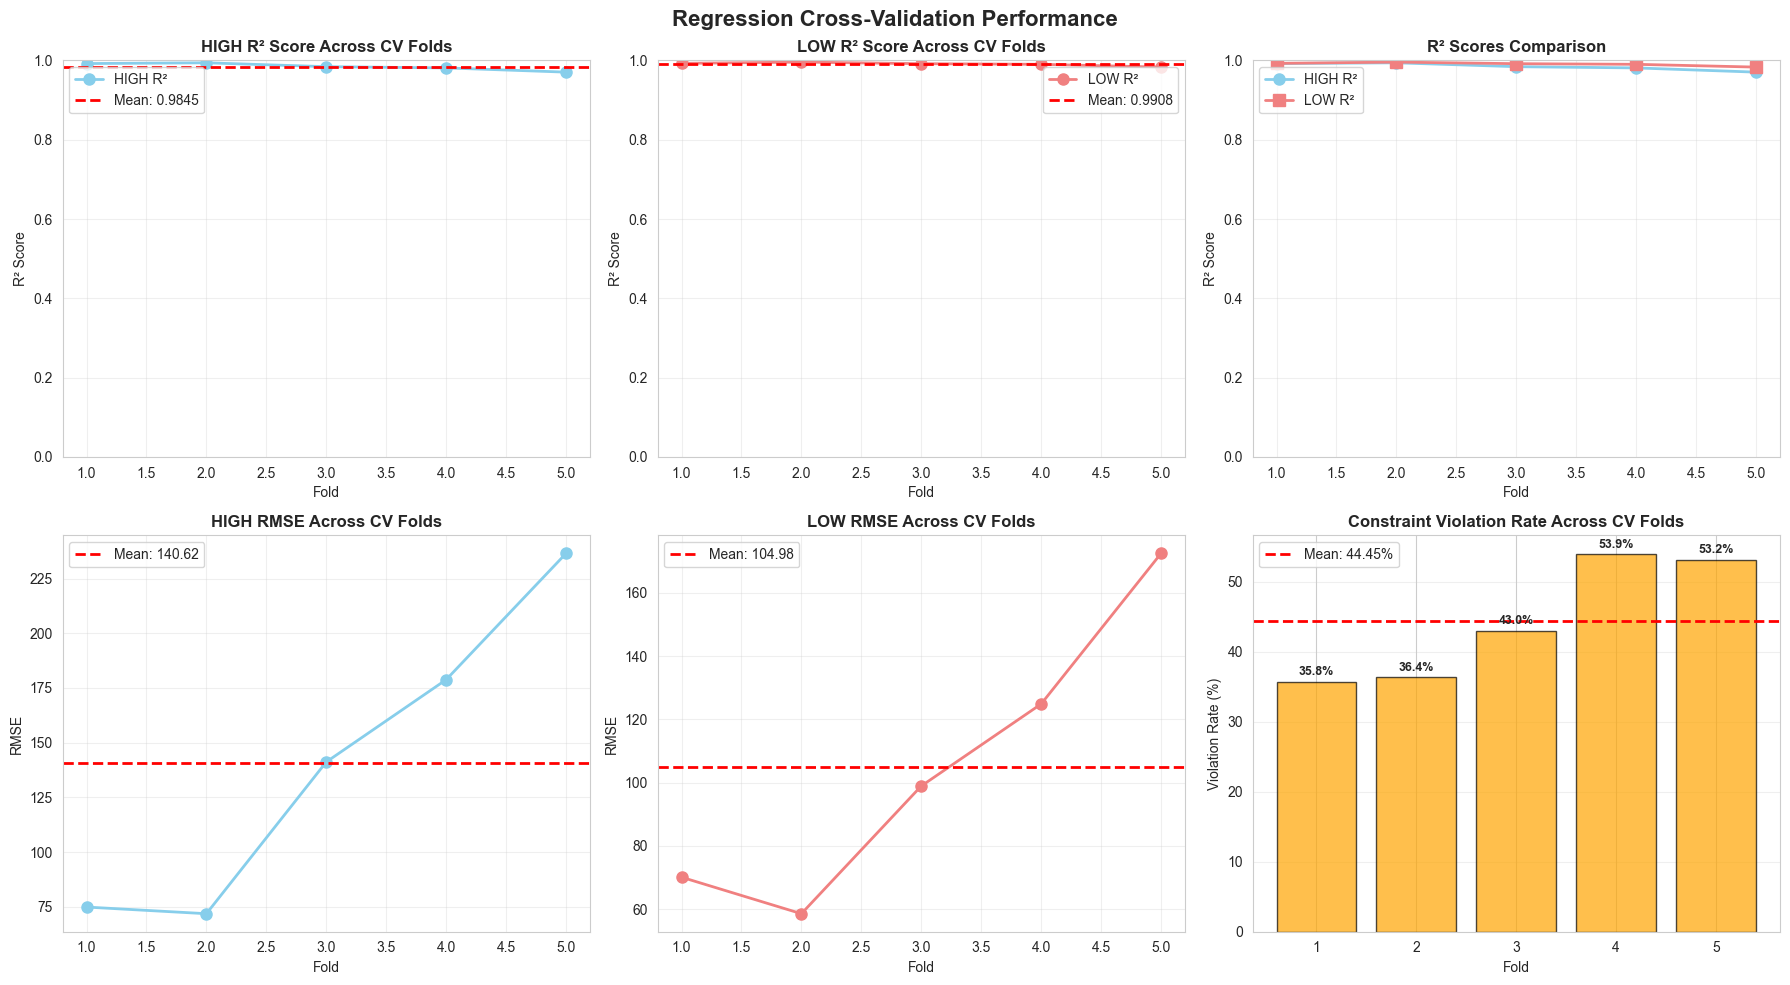

✓ Regression cross-validation visualization saved


In [37]:
# Regression Cross-Validation Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. HIGH R² across folds
ax1 = axes[0, 0]
ax1.plot(cv_regression_df['Fold'], cv_regression_df['HIGH_R2'], 'o-', 
         linewidth=2, markersize=8, color='skyblue', label='HIGH R²')
ax1.axhline(y=cv_regression_df['HIGH_R2'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f"Mean: {cv_regression_df['HIGH_R2'].mean():.4f}")
ax1.set_title('HIGH R² Score Across CV Folds', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('R² Score')
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(alpha=0.3)

# 2. LOW R² across folds
ax2 = axes[0, 1]
ax2.plot(cv_regression_df['Fold'], cv_regression_df['LOW_R2'], 'o-',
         linewidth=2, markersize=8, color='lightcoral', label='LOW R²')
ax2.axhline(y=cv_regression_df['LOW_R2'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_regression_df['LOW_R2'].mean():.4f}")
ax2.set_title('LOW R² Score Across CV Folds', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fold')
ax2.set_ylabel('R² Score')
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Combined R² comparison
ax3 = axes[0, 2]
x_folds = cv_regression_df['Fold']
ax3.plot(x_folds, cv_regression_df['HIGH_R2'], 'o-', linewidth=2, markersize=8,
         color='skyblue', label='HIGH R²')
ax3.plot(x_folds, cv_regression_df['LOW_R2'], 's-', linewidth=2, markersize=8,
         color='lightcoral', label='LOW R²')
ax3.set_title('R² Scores Comparison', fontsize=12, fontweight='bold')
ax3.set_xlabel('Fold')
ax3.set_ylabel('R² Score')
ax3.set_ylim([0, 1])
ax3.legend()
ax3.grid(alpha=0.3)

# 4. HIGH RMSE across folds
ax4 = axes[1, 0]
ax4.plot(cv_regression_df['Fold'], cv_regression_df['HIGH_RMSE'], 'o-',
         linewidth=2, markersize=8, color='skyblue')
ax4.axhline(y=cv_regression_df['HIGH_RMSE'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_regression_df['HIGH_RMSE'].mean():.2f}")
ax4.set_title('HIGH RMSE Across CV Folds', fontsize=12, fontweight='bold')
ax4.set_xlabel('Fold')
ax4.set_ylabel('RMSE')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. LOW RMSE across folds
ax5 = axes[1, 1]
ax5.plot(cv_regression_df['Fold'], cv_regression_df['LOW_RMSE'], 'o-',
         linewidth=2, markersize=8, color='lightcoral')
ax5.axhline(y=cv_regression_df['LOW_RMSE'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_regression_df['LOW_RMSE'].mean():.2f}")
ax5.set_title('LOW RMSE Across CV Folds', fontsize=12, fontweight='bold')
ax5.set_xlabel('Fold')
ax5.set_ylabel('RMSE')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Violation Rate across folds
ax6 = axes[1, 2]
bars = ax6.bar(cv_regression_df['Fold'], cv_regression_df['Violation_Rate'],
               color='orange', edgecolor='black', alpha=0.7)
ax6.axhline(y=cv_regression_df['Violation_Rate'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {cv_regression_df['Violation_Rate'].mean():.2f}%")
ax6.set_title('Constraint Violation Rate Across CV Folds', fontsize=12, fontweight='bold')
ax6.set_xlabel('Fold')
ax6.set_ylabel('Violation Rate (%)')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Regression Cross-Validation Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'regression_cross_validation.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Regression cross-validation visualization saved")

## 13. Company-wise Time Series Predictions

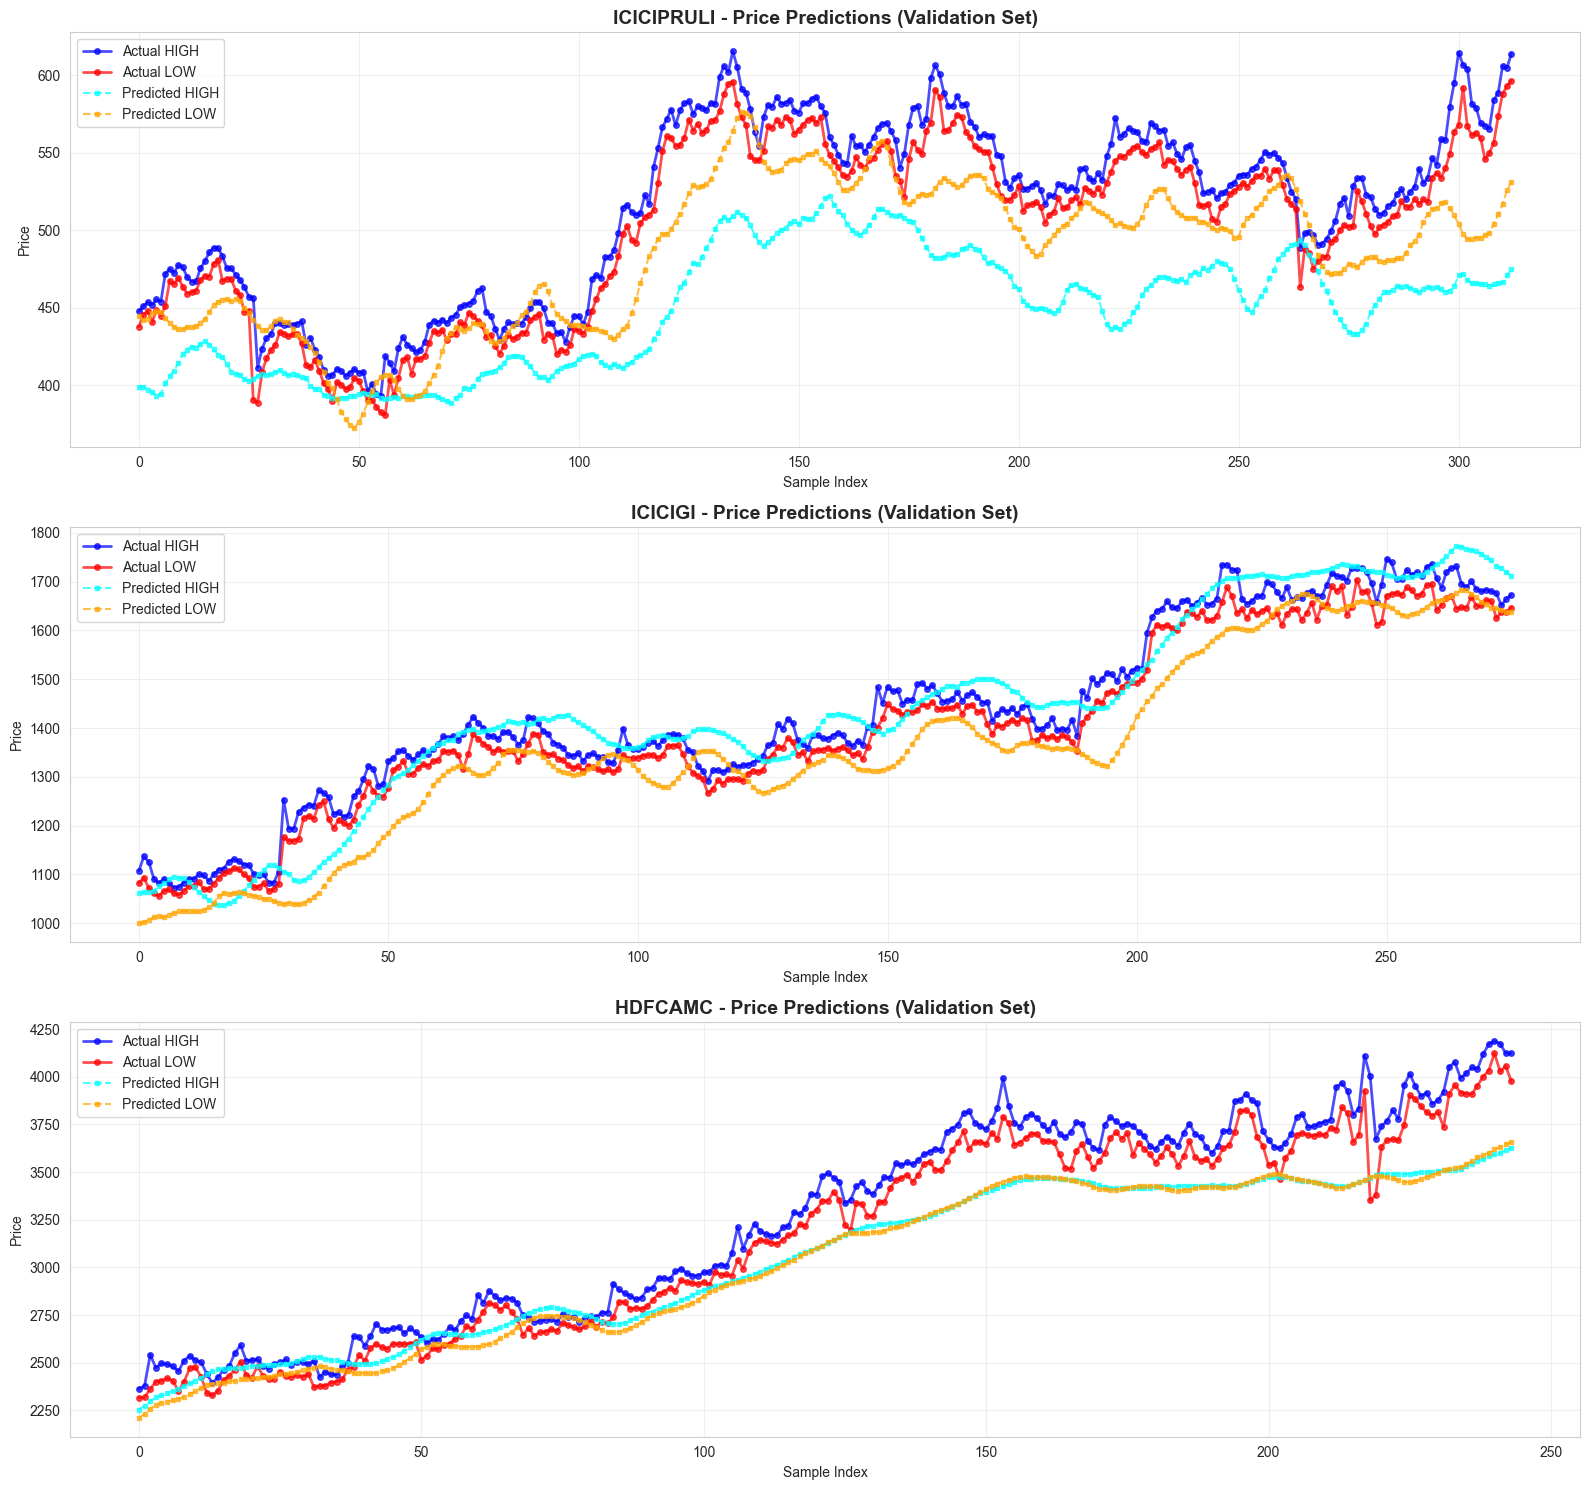

✓ Company-wise time series visualization saved


In [38]:
# Plot time series predictions for each company
fig, axes = plt.subplots(len(CLUSTER_STOCKS), 1, figsize=(16, 5*len(CLUSTER_STOCKS)))

for idx, stock in enumerate(CLUSTER_STOCKS):
    ax = axes[idx] if len(CLUSTER_STOCKS) > 1 else axes
    
    # Get stock data
    stock_mask = np.array(val_stocks) == stock
    
    if stock_mask.sum() > 0:
        stock_high_actual = y_high_val_seq[stock_mask]
        stock_high_pred = y_high_val_pred[stock_mask]
        stock_low_actual = y_low_val_seq[stock_mask]
        stock_low_pred = y_low_val_pred[stock_mask]
        
        x_range = np.arange(len(stock_high_actual))
        
        # Plot actual
        ax.plot(x_range, stock_high_actual, 'o-', linewidth=2, markersize=4, 
                label='Actual HIGH', color='blue', alpha=0.7)
        ax.plot(x_range, stock_low_actual, 'o-', linewidth=2, markersize=4,
                label='Actual LOW', color='red', alpha=0.7)
        
        # Plot predicted
        ax.plot(x_range, stock_high_pred, 's--', linewidth=1.5, markersize=3,
                label='Predicted HIGH', color='cyan', alpha=0.7)
        ax.plot(x_range, stock_low_pred, 's--', linewidth=1.5, markersize=3,
                label='Predicted LOW', color='orange', alpha=0.7)
        
        ax.set_title(f'{stock} - Price Predictions (Validation Set)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Price')
        ax.legend(loc='best')
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'company_wise_timeseries.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Company-wise time series visualization saved")

## 13b. Integrated CSV Analysis and Visualization

In [39]:
print("="*80)
print("READING AND ANALYZING INTEGRATED CSV FILES")
print("="*80)

# Read integrated CSV files for each company
integrated_dfs = {}
for stock in CLUSTER_STOCKS:
    csv_path = os.path.join(OUTPUT_DIR, f'{stock}_validation_integrated.csv')
    if os.path.exists(csv_path):
        integrated_dfs[stock] = pd.read_csv(csv_path)
        integrated_dfs[stock]['date'] = pd.to_datetime(integrated_dfs[stock]['date'])
        print(f"✓ {stock}: {len(integrated_dfs[stock])} records loaded")
    else:
        print(f"⚠️ {stock}: File not found at {csv_path}")

print(f"\n✓ Total companies loaded: {len(integrated_dfs)}")

# Display sample data
if len(integrated_dfs) > 0:
    sample_stock = list(integrated_dfs.keys())[0]
    print(f"\n📊 Sample data from {sample_stock}:")
    print(integrated_dfs[sample_stock].head())
    print(f"\n📊 Columns: {list(integrated_dfs[sample_stock].columns)}")

READING AND ANALYZING INTEGRATED CSV FILES
✓ ICICIPRULI: 313 records loaded
✓ ICICIGI: 276 records loaded
✓ HDFCAMC: 244 records loaded

✓ Total companies loaded: 3

📊 Sample data from ICICIPRULI:
        date  volume  actual_high  actual_low  predicted_low  predicted_high  \
0 2022-12-26  181523        447.7      437.70      444.71146       398.78424   
1 2022-12-27  311092        451.0      445.65      442.21292       398.84810   
2 2022-12-28  108028        453.6      448.00      442.79672       397.24290   
3 2022-12-29  224473        452.0      440.85      446.92975       395.70447   
4 2022-12-30  176553        455.4      448.55      447.61310       393.15920   

  buy_sell_label  
0            BUY  
1            BUY  
2            BUY  
3           SELL  
4            BUY  

📊 Columns: ['date', 'volume', 'actual_high', 'actual_low', 'predicted_low', 'predicted_high', 'buy_sell_label']


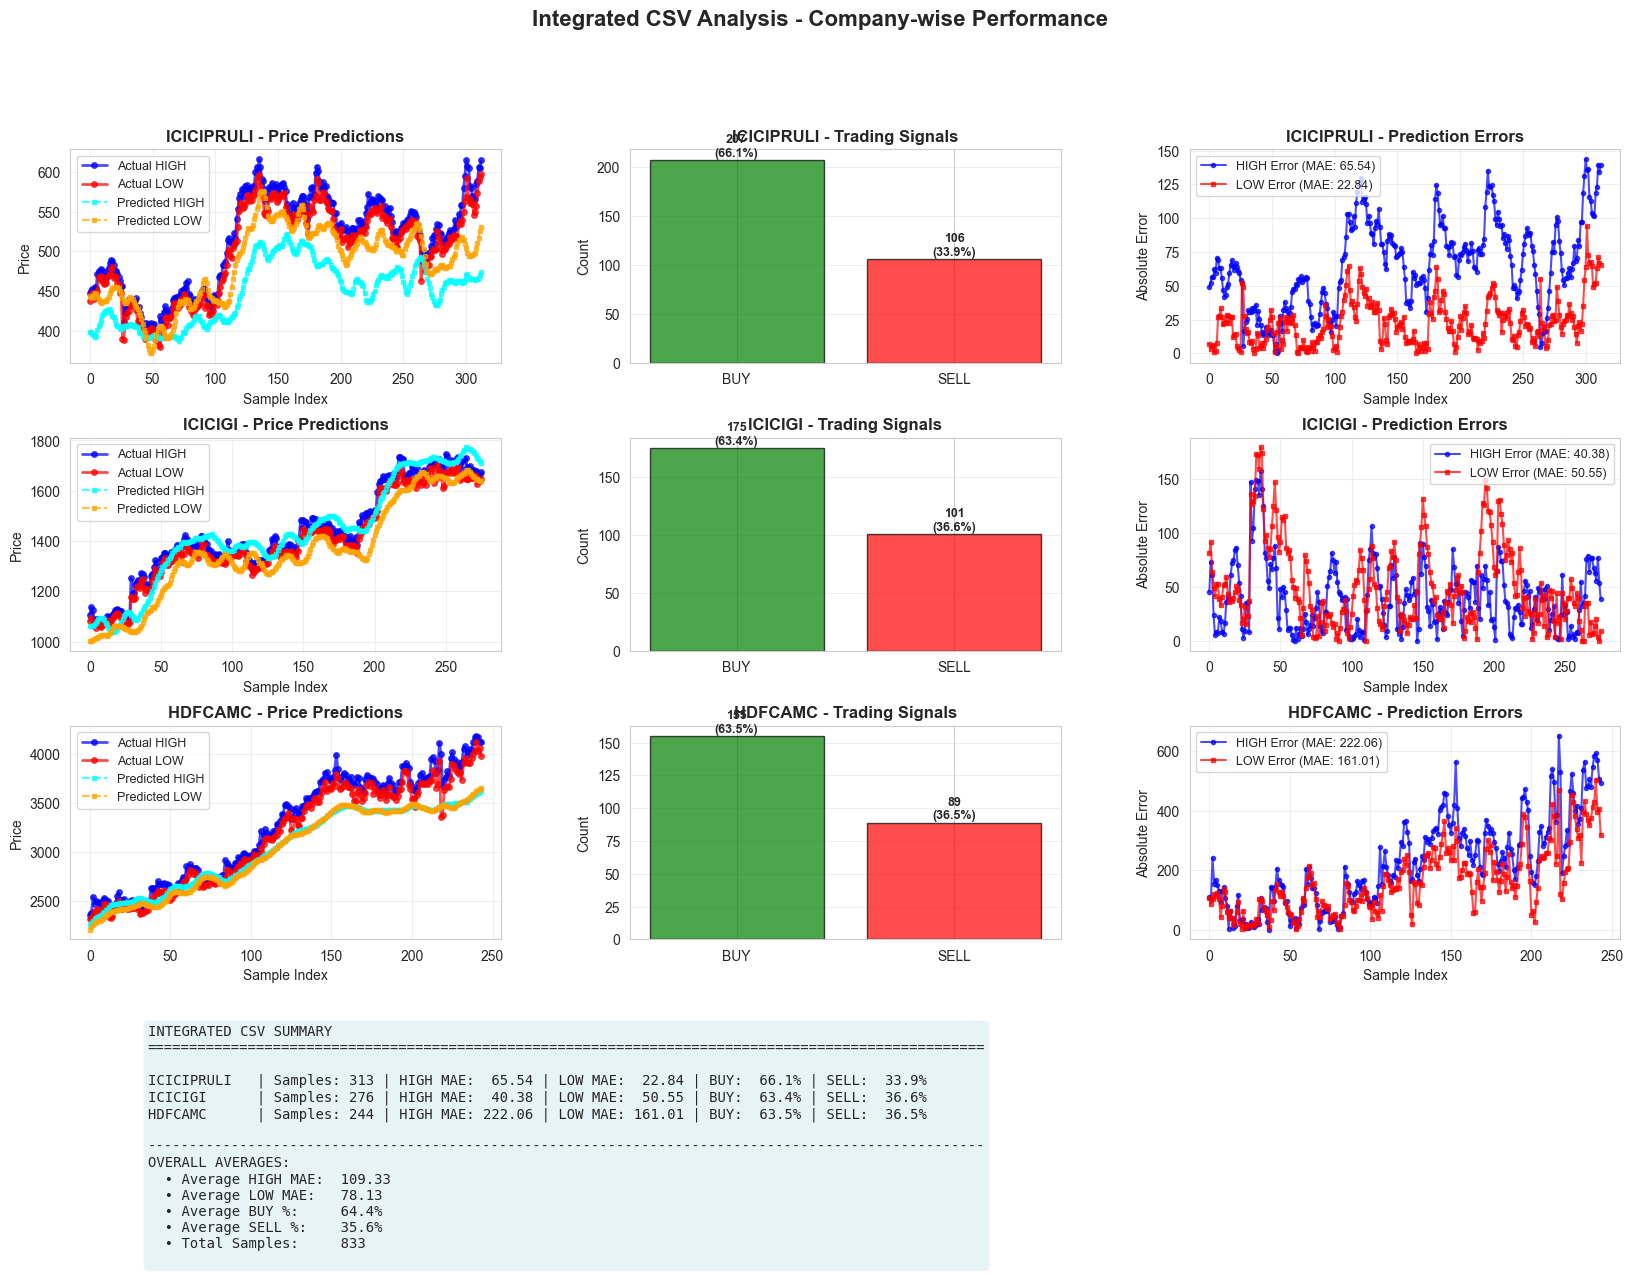


✓ Integrated CSV visualization saved


In [40]:
# Comprehensive visualization of integrated CSV data
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

for idx, stock in enumerate(CLUSTER_STOCKS):
    if stock not in integrated_dfs:
        continue
    
    df = integrated_dfs[stock]
    
    # Row for this stock
    row = idx
    
    # 1. Price predictions over time
    ax1 = fig.add_subplot(gs[row, 0])
    ax1.plot(df.index, df['actual_high'], 'o-', linewidth=2, markersize=4,
             label='Actual HIGH', color='blue', alpha=0.7)
    ax1.plot(df.index, df['actual_low'], 'o-', linewidth=2, markersize=4,
             label='Actual LOW', color='red', alpha=0.7)
    ax1.plot(df.index, df['predicted_high'], 's--', linewidth=1.5, markersize=3,
             label='Predicted HIGH', color='cyan', alpha=0.7)
    ax1.plot(df.index, df['predicted_low'], 's--', linewidth=1.5, markersize=3,
             label='Predicted LOW', color='orange', alpha=0.7)
    ax1.set_title(f'{stock} - Price Predictions', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # 2. Buy/Sell signals distribution
    ax2 = fig.add_subplot(gs[row, 1])
    signal_counts = df['buy_sell_label'].value_counts()
    colors_signal = ['green' if x == 'BUY' else 'red' for x in signal_counts.index]
    bars = ax2.bar(signal_counts.index, signal_counts.values, 
                   color=colors_signal, edgecolor='black', alpha=0.7)
    ax2.set_title(f'{stock} - Trading Signals', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Count')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(df)
    for bar, count in zip(bars, signal_counts.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(count)}\n({count/total*100:.1f}%)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 3. Prediction errors
    ax3 = fig.add_subplot(gs[row, 2])
    high_error = np.abs(df['actual_high'] - df['predicted_high'])
    low_error = np.abs(df['actual_low'] - df['predicted_low'])
    
    ax3.plot(df.index, high_error, 'o-', linewidth=1.5, markersize=3,
             label=f'HIGH Error (MAE: {high_error.mean():.2f})', color='blue', alpha=0.7)
    ax3.plot(df.index, low_error, 's-', linewidth=1.5, markersize=3,
             label=f'LOW Error (MAE: {low_error.mean():.2f})', color='red', alpha=0.7)
    ax3.set_title(f'{stock} - Prediction Errors', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('Absolute Error')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(alpha=0.3)

# Overall summary in the last row
ax_summary = fig.add_subplot(gs[3, :])
ax_summary.axis('off')

# Compute overall statistics
overall_stats = []
for stock in CLUSTER_STOCKS:
    if stock not in integrated_dfs:
        continue
    df = integrated_dfs[stock]
    high_mae = np.abs(df['actual_high'] - df['predicted_high']).mean()
    low_mae = np.abs(df['actual_low'] - df['predicted_low']).mean()
    buy_pct = (df['buy_sell_label'] == 'BUY').sum() / len(df) * 100
    sell_pct = (df['buy_sell_label'] == 'SELL').sum() / len(df) * 100
    
    overall_stats.append({
        'Stock': stock,
        'Samples': len(df),
        'HIGH MAE': high_mae,
        'LOW MAE': low_mae,
        'BUY %': buy_pct,
        'SELL %': sell_pct
    })

stats_df = pd.DataFrame(overall_stats)

summary_text = "INTEGRATED CSV SUMMARY\n" + "="*100 + "\n\n"
for _, row in stats_df.iterrows():
    summary_text += f"{row['Stock']:12s} | Samples: {int(row['Samples']):3d} | "
    summary_text += f"HIGH MAE: {row['HIGH MAE']:6.2f} | LOW MAE: {row['LOW MAE']:6.2f} | "
    summary_text += f"BUY: {row['BUY %']:5.1f}% | SELL: {row['SELL %']:5.1f}%\n"

summary_text += "\n" + "-"*100 + "\n"
summary_text += f"OVERALL AVERAGES:\n"
summary_text += f"  • Average HIGH MAE:  {stats_df['HIGH MAE'].mean():.2f}\n"
summary_text += f"  • Average LOW MAE:   {stats_df['LOW MAE'].mean():.2f}\n"
summary_text += f"  • Average BUY %:     {stats_df['BUY %'].mean():.1f}%\n"
summary_text += f"  • Average SELL %:    {stats_df['SELL %'].mean():.1f}%\n"
summary_text += f"  • Total Samples:     {stats_df['Samples'].sum()}\n"

ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Integrated CSV Analysis - Company-wise Performance', fontsize=16, fontweight='bold')
plt.savefig(os.path.join(OUTPUT_DIR, 'integrated_csv_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Integrated CSV visualization saved")

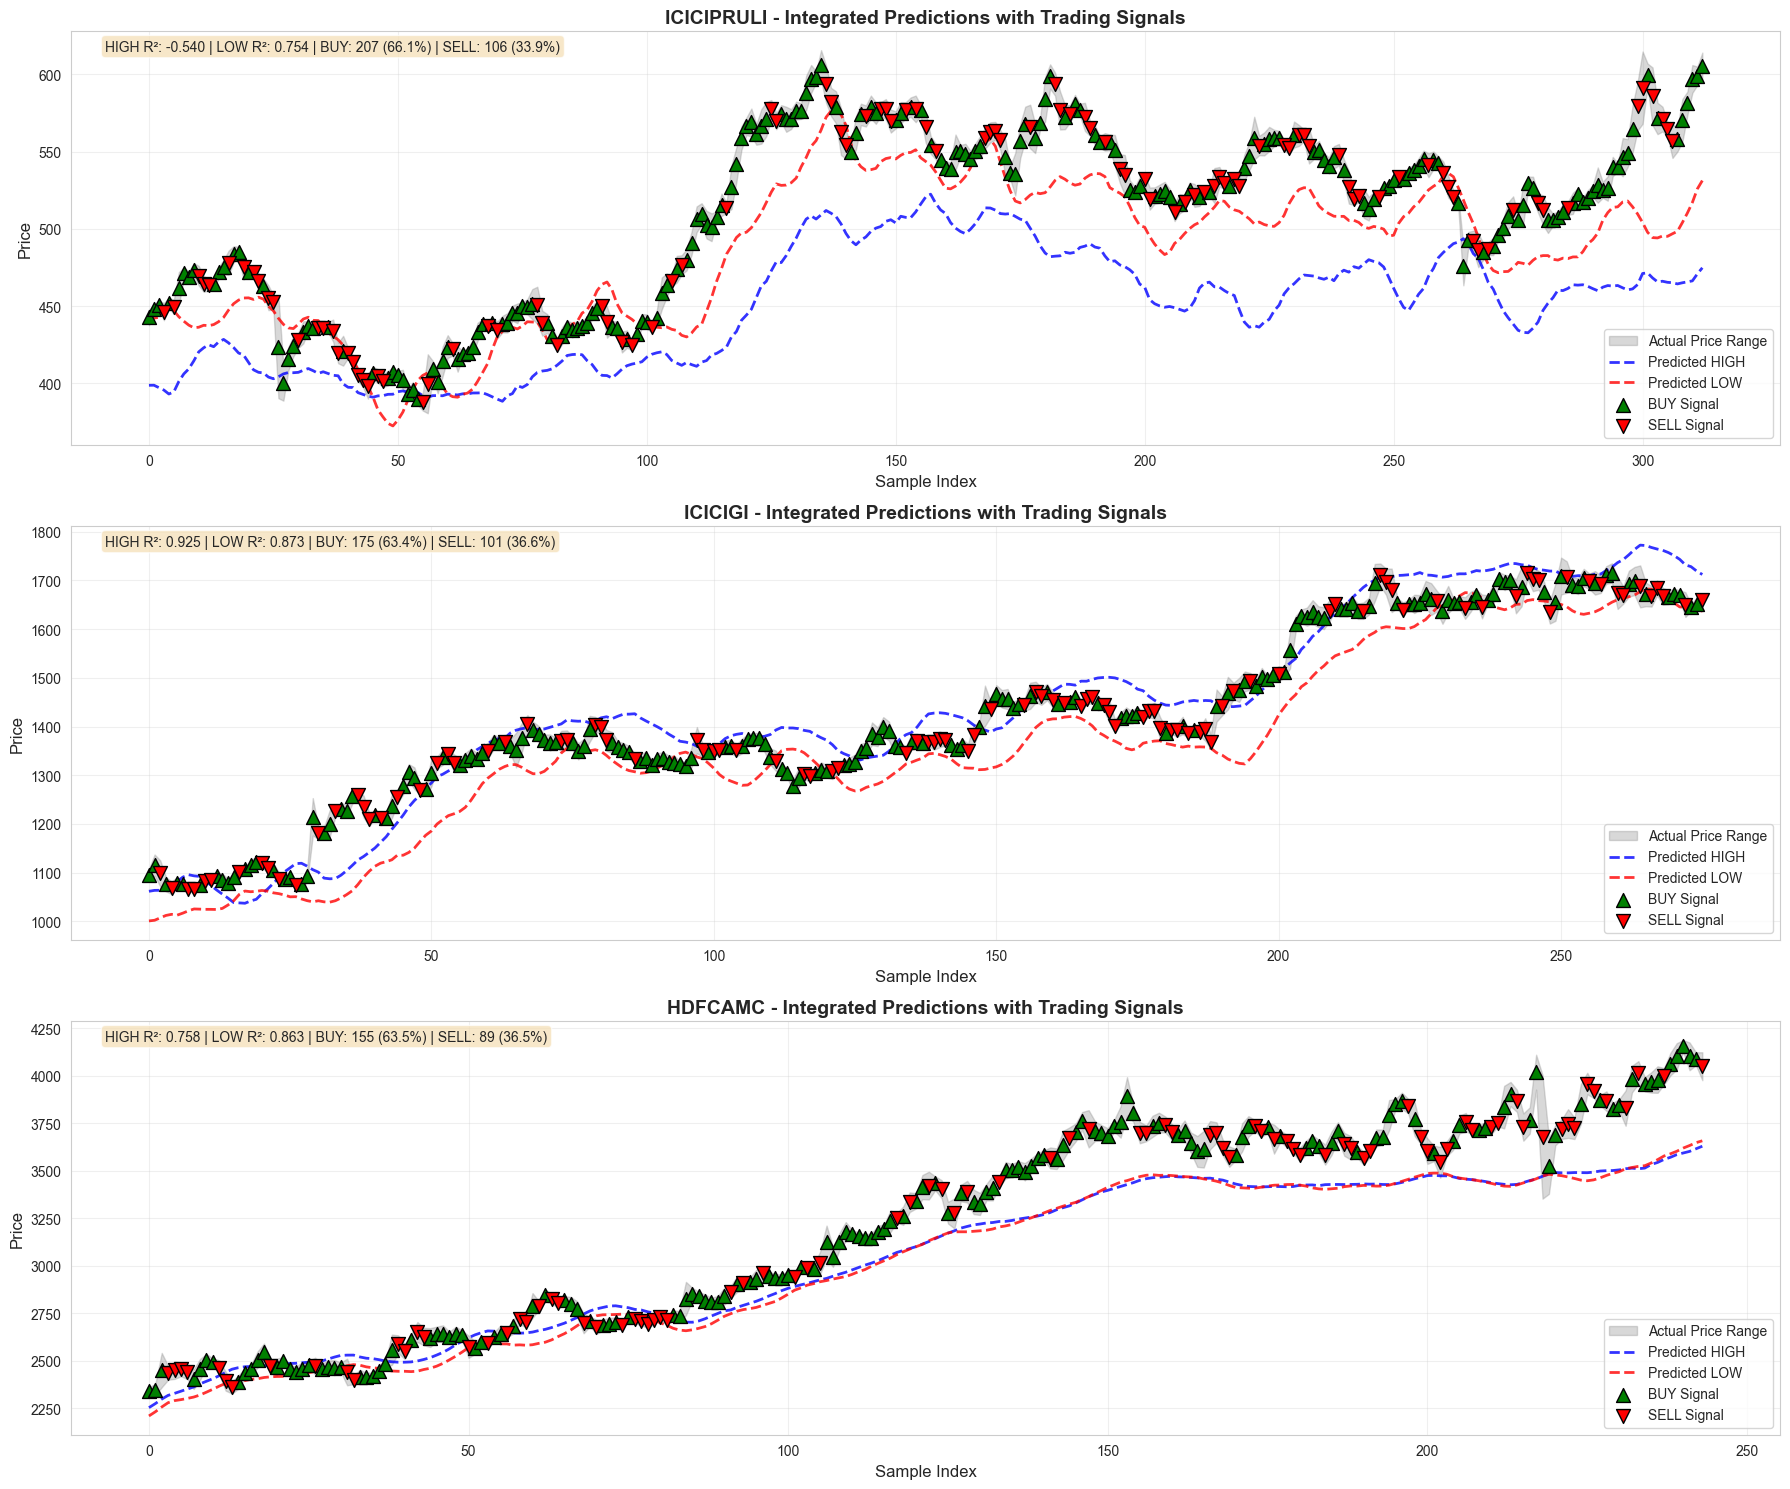

✓ Integrated signals time series visualization saved


In [41]:
# Time series with buy/sell signals overlay
fig, axes = plt.subplots(len(CLUSTER_STOCKS), 1, figsize=(18, 5*len(CLUSTER_STOCKS)))

if len(CLUSTER_STOCKS) == 1:
    axes = [axes]

for idx, stock in enumerate(CLUSTER_STOCKS):
    if stock not in integrated_dfs:
        continue
    
    df = integrated_dfs[stock]
    ax = axes[idx]
    
    # Plot price range (HIGH-LOW) as shaded area
    ax.fill_between(df.index, df['actual_low'], df['actual_high'],
                     alpha=0.3, color='gray', label='Actual Price Range')
    
    # Plot predicted range
    ax.plot(df.index, df['predicted_high'], '--', linewidth=2,
            color='blue', label='Predicted HIGH', alpha=0.8)
    ax.plot(df.index, df['predicted_low'], '--', linewidth=2,
            color='red', label='Predicted LOW', alpha=0.8)
    
    # Overlay buy/sell signals
    buy_mask = df['buy_sell_label'] == 'BUY'
    sell_mask = df['buy_sell_label'] == 'SELL'
    
    # Calculate midpoint for signal markers
    midpoint = (df['actual_high'] + df['actual_low']) / 2
    
    ax.scatter(df.index[buy_mask], midpoint[buy_mask], 
               marker='^', s=100, color='green', label='BUY Signal',
               edgecolors='black', linewidth=1, zorder=5)
    ax.scatter(df.index[sell_mask], midpoint[sell_mask],
               marker='v', s=100, color='red', label='SELL Signal',
               edgecolors='black', linewidth=1, zorder=5)
    
    ax.set_title(f'{stock} - Integrated Predictions with Trading Signals', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)
    
    # Add statistics as text
    high_r2 = 1 - ((df['actual_high'] - df['predicted_high'])**2).sum() / ((df['actual_high'] - df['actual_high'].mean())**2).sum()
    low_r2 = 1 - ((df['actual_low'] - df['predicted_low'])**2).sum() / ((df['actual_low'] - df['actual_low'].mean())**2).sum()
    buy_count = buy_mask.sum()
    sell_count = sell_mask.sum()
    
    stats_text = f"HIGH R²: {high_r2:.3f} | LOW R²: {low_r2:.3f} | BUY: {buy_count} ({buy_count/len(df)*100:.1f}%) | SELL: {sell_count} ({sell_count/len(df)*100:.1f}%)"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'integrated_signals_timeseries.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Integrated signals time series visualization saved")

## 14. Final Summary Report

In [42]:
print("\n" + "="*80)
print("VALIDATION PIPELINE - FINAL SUMMARY")
print("="*80)

print("\n📊 CLASSIFICATION MODEL:")
print("-" * 80)
print(f"Overall Performance:")
print(f"  • Accuracy:  {val_accuracy:.4f}")
print(f"  • F2 Score:  {val_f2:.4f}")
print(f"  • AUC-ROC:   {val_auc:.4f}")

print(f"\nCross-Validation Performance:")
print(f"  • Accuracy:  {cv_classification_df['Accuracy'].mean():.4f} ± {cv_classification_df['Accuracy'].std():.4f}")
print(f"  • F2 Score:  {cv_classification_df['F2_Score'].mean():.4f} ± {cv_classification_df['F2_Score'].std():.4f}")
print(f"  • AUC:       {cv_classification_df['AUC'].mean():.4f} ± {cv_classification_df['AUC'].std():.4f}")

print(f"\nCompany-wise Best Performer:")
best_stock_class = classification_df.loc[classification_df['F2_Score'].idxmax()]
print(f"  • Stock:     {best_stock_class['Stock']}")
print(f"  • F2 Score:  {best_stock_class['F2_Score']:.4f}")
print(f"  • Accuracy:  {best_stock_class['Accuracy']:.4f}")

print("\n\n📈 REGRESSION MODEL:")
print("-" * 80)
print(f"HIGH Price Prediction:")
print(f"  • R² Score:  {high_r2:.4f}")
print(f"  • RMSE:      {high_rmse:.2f}")
print(f"  • MAE:       {high_mae:.2f}")
print(f"  • MAPE:      {high_mape:.2f}%")

print(f"\nLOW Price Prediction:")
print(f"  • R² Score:  {low_r2:.4f}")
print(f"  • RMSE:      {low_rmse:.2f}")
print(f"  • MAE:       {low_mae:.2f}")
print(f"  • MAPE:      {low_mape:.2f}%")

print(f"\nConstraint Violations:")
print(f"  • Total:     {violations} / {len(y_low_val_pred)}")
print(f"  • Rate:      {violations/len(y_low_val_pred)*100:.2f}%")

print(f"\nCross-Validation Performance (Regression):")
print(f"  • HIGH R²:   {cv_regression_df['HIGH_R2'].mean():.4f} ± {cv_regression_df['HIGH_R2'].std():.4f}")
print(f"  • HIGH RMSE: {cv_regression_df['HIGH_RMSE'].mean():.2f} ± {cv_regression_df['HIGH_RMSE'].std():.2f}")
print(f"  • LOW R²:    {cv_regression_df['LOW_R2'].mean():.4f} ± {cv_regression_df['LOW_R2'].std():.4f}")
print(f"  • LOW RMSE:  {cv_regression_df['LOW_RMSE'].mean():.2f} ± {cv_regression_df['LOW_RMSE'].std():.2f}")
print(f"  • Violation Rate: {cv_regression_df['Violation_Rate'].mean():.2f}% ± {cv_regression_df['Violation_Rate'].std():.2f}%")

print(f"\nCompany-wise Best Performer (HIGH):")
best_stock_reg = regression_df.loc[regression_df['HIGH_R2'].idxmax()]
print(f"  • Stock:     {best_stock_reg['Stock']}")
print(f"  • HIGH R²:   {best_stock_reg['HIGH_R2']:.4f}")
print(f"  • LOW R²:    {best_stock_reg['LOW_R2']:.4f}")

print("\n\n📁 OUTPUT FILES:")
print("-" * 80)
print(f"CSV Files:")
print(f"  • validation_classification_predictions.csv")
print(f"  • validation_regression_predictions.csv")
print(f"  • company_wise_classification.csv")
print(f"  • company_wise_regression.csv")
print(f"  • cross_validation_classification.csv")
print(f"  • cross_validation_regression.csv")

print(f"\nVisualization Files:")
print(f"  • classification_performance.png")
print(f"  • regression_performance.png")
print(f"  • regression_cross_validation.png")
print(f"  • company_wise_timeseries.png")

print(f"\nAll files saved to: {OUTPUT_DIR}")

print("\n" + "="*80)
print("✅ VALIDATION PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)


VALIDATION PIPELINE - FINAL SUMMARY

📊 CLASSIFICATION MODEL:
--------------------------------------------------------------------------------
Overall Performance:
  • Accuracy:  0.8371
  • F2 Score:  0.9287
  • AUC-ROC:   0.9575

Cross-Validation Performance:
  • Accuracy:  0.8384 ± 0.0507
  • F2 Score:  0.9284 ± 0.0251
  • AUC:       0.9569 ± 0.0121

Company-wise Best Performer:
  • Stock:     ICICIPRULI
  • F2 Score:  0.9385
  • Accuracy:  0.8506


📈 REGRESSION MODEL:
--------------------------------------------------------------------------------
HIGH Price Prediction:
  • R² Score:  0.7584
  • RMSE:      155.00
  • MAE:       222.06
  • MAPE:      7.44%

LOW Price Prediction:
  • R² Score:  0.8631
  • RMSE:      113.38
  • MAE:       161.01
  • MAPE:      4.30%

Constraint Violations:
  • Total:     371 / 833
  • Rate:      44.54%

Cross-Validation Performance (Regression):
  • HIGH R²:   0.9845 ± 0.0094
  • HIGH RMSE: 140.62 ± 70.19
  • LOW R²:    0.9908 ± 0.0047
  • LOW RMSE:  1